## Import

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP, ZeroInflatedNegativeBinomialResults
import statsmodels.formula.api as smf
import patsy
import pingouin as pg

## Infók:
1. mintavételi pontok: MV23, Tap3 --> site_id
2. vízgyűjtő: Észak vagy Dél --> site
3. groups: PPCP and pesticids
4. drop:
    - Jegyzőkönyv száma	
    - Vizsgálat ideje (kezdete)
4. values:
    - "-" = BDL =0(?)
    - NA = not studied - NaN
/
5. Van-e különbség a É és D között?
    - elemszám: PPCPs_count and pesticids_count
    - koncentráció: PPCPs_cc and pesticids_cc
6. Esetleg 2021 vs 2022?
    - elemszám
    - koncentráció


## Load the data

In [291]:
data1 = pd.read_excel("data/chemical_compounds_surface_water_data.xlsx", sheet_name="Táblázat1", header=1)
data2 = pd.read_excel("data/chemical_compounds_surface_water_data.xlsx", sheet_name="Táblázat2")

In [3]:
data1.rename(columns={"Unnamed: 0" : "info", "Unnamed: 1": "type"}, inplace=True)

In [4]:
data1.head()

,info,type,MV23,MV23.1,MV23.2,MV32,MV32.1,BUR2,BUR3,BUR3.1,...,TAP3.3,TAP3.4,ZALA1,ZALA1.1,ZALA1.2,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80
0,Jegyzőkönyv száma,NaN,676343/1,746962/1,751256/1,676343/1,746962/1,746933/1,676343/1,689868/1,...,752721/1,758994/1,676343/1,746933/1,758996/1,NaN,NaN,NaN,NaN,NaN
1,Vizsgálat ideje (kezdete),NaN,2021-06-29 00:00:00,2022-07-04 00:00:00,2022-07-22 00:00:00,2021-06-29 00:00:00,2022-07-04 00:00:00,2022-07-04 00:00:00,2021-06-29 00:00:00,2021-09-08 00:00:00,...,2022-07-27 00:00:00,2022-08-30 00:00:00,2021-06-29 00:00:00,2022-07-04 00:00:00,2022-08-30 00:00:00,NaN,NaN,NaN,NaN,NaN
2,Vízgyűjtő,NaN,D,D,D,D,D,É,É,É,...,É,É,D,D,D,Anyagnév,Előfordulás (FO),Koncentráció (átlag),Koncentráció (max),SZUM
3,PPCPs,Típus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4-Metoxi-fahéjsav-2-etilhexil-észter 1,UV szűrő,NaN,-,NaN,NaN,-,NaN,-,0.01,...,NaN,-,NaN,-,NaN,4-Metoxi-fahéjsav-2-etilhexil-észter,0.040541,0.023333,0.03,0.07


In [5]:
data2.head()

,Oszlop1,Jegyzőkönyv száma,Vizsgálat ideje (kezdete),Vízgyűjtő,Egyéb,PPCPs,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,...,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1,Unnamed: 82,Unnamed: 83
0,NaN,NaN,NaT,NaN,ÉV,NaN,sztatin,UV szűrő,antibiotikum (makrolid),béta-blokkoló,...,herbicid,herbicid,fungicid,inszekticid,fungicid,fungicid,herbicid,herbicid,NaN,NaN
1,MV23,676343/1,2021-06-29,D,2021,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,NaN,NaN
2,MV23,746962/1,2022-07-04,D,2022,NaN,-,-,-,-,...,-,-,-,-,-,-,-,-,NaN,NaN
3,MV23,751256/1,2022-07-22,D,2022,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,NaN,NaN
4,MV32,676343/1,2021-06-29,D,2021,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,NaN,NaN


## Preprocessing

In [292]:
data2.drop(columns=["Jegyzőkönyv száma", "Unnamed: 82", "Unnamed: 83"], inplace=True)
data2.rename(columns={"Oszlop1": "site_id", "Vízgyűjtő": "location", "Egyéb": "year", "Vizsgálat ideje (kezdete)": "sampling_date"}, inplace=True)

In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 81 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   site_id                                 74 non-null     object        
 1   sampling_date                           74 non-null     datetime64[ns]
 2   location                                74 non-null     object        
 3   year                                    75 non-null     object        
 4   PPCPs                                   0 non-null      float64       
 5   Atorvasztatin 1                         44 non-null     object        
 6   4-Metoxi-fahéjsav-2-etilhexil-észter 1  38 non-null     object        
 7   Azitromicin 1                           44 non-null     object        
 8   Betaxolol 1                             44 non-null     object        
 9   Bikalutamid 1                           44 non-null     

In [293]:
# Write substances and substance types to a new dictionary
metadata_cols = ["site_id", "location", "sampling_date", "year", "substance", "PPCPs", "Peszticid"]
substance_cols = [col for col in data2.columns if col not in metadata_cols]
substance_type = [type for type in data2.iloc[0, 4:]]

# Create the dictionary
substance_types = dict(zip(substance_cols, substance_type))

In [9]:
substance_types

{'Atorvasztatin 1': np.float64(nan),
 '4-Metoxi-fahéjsav-2-etilhexil-észter 1': 'sztatin',
 'Azitromicin 1': 'UV szűrő',
 'Betaxolol 1': 'antibiotikum (makrolid)',
 'Bikalutamid 1': 'béta-blokkoló',
 'Cimetidin 1': 'antiandrogén',
 'Biszoprolol 1': 'savlekötő (PPI)',
 'DEET 1': 'béta-blokkoló',
 'Dezloratadin 1': 'inszekticid (nem növényvédőszer!)',
 'Dihidrokodein 1': 'antihisztamin',
 'Diklofenák 1': 'köhögéscsillapító',
 'Eritromicin 1, 2': 'gyulladáscsökkentő (NSAID)',
 'Famotidin 1': 'antibiotikum (makrolid)',
 'Fenobarbitál 1': 'savlekötő (PPI)',
 'Furoszemid 1, 2': 'antiepileptikum',
 'Hidroklórtiazid 1, 2': 'vizelethajtó',
 'Ibuprofén 1': 'vizelethajtó',
 'Indapamid 1': 'gyulladáscsökkentő (NSAID)',
 'Jopamidol 1, 2': 'vizelethajtó',
 'Jopromid 1, 2': 'kontraszt anyag',
 'Karbamazepin 1': 'kontraszt anyag',
 'Ketoprofén 1, 2': 'antiepileptikum',
 'Klaritromicin 1': 'gyulladáscsökkentő (NSAID)',
 'Klindamicin 1': 'anitbiotikum',
 'Kodein 1': 'antibiotikum',
 'Koffein 1, 2': 'köh

In [294]:
data2.drop(axis=1, index=0, inplace=True)  # Remove the first row which contains the substance types
data2.head()

,site_id,sampling_date,location,year,PPCPs,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,Bikalutamid 1,...,Mekoprop 1,Metolaklór 1,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1
1,MV23,2021-06-29,D,2021,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
2,MV23,2022-07-04,D,2022,NaN,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,MV23,2022-07-22,D,2022,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
4,MV32,2021-06-29,D,2021,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
5,MV32,2022-07-04,D,2022,NaN,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [296]:
data2["Peszticid"] = np.nan
# Convert "-" to 0
data2.replace("-", 0, inplace=True)

In [12]:
# Find columns with all NaN values
nan_cols = [col for col in substance_cols if data2[col].isna().all()]

# Drop columns with all NaN values
data2.drop(columns=nan_cols, inplace=True)

# Print the dropped columns
print("Dropped columns with all NaN values:", nan_cols)
for col in nan_cols:
    print(f" - {col}")

Dropped columns with all NaN values: []


In [13]:
# Find rows with all NaN values in substance columns
nan_rows = data2[substance_cols].isna().all(axis=1)

# Print site_id values of these rows
print("Dropping sampling sites where all substances were NaN:")
print(data2.loc[nan_rows, "site_id"].tolist())

# Drop the rows
data2 = data2.loc[~nan_rows].reset_index(drop=True)

Dropping sampling sites where all substances were NaN:
[]


In [14]:
# Calculate number of above-threshold-values for each substance
def count_above_threshold(data, subset_cols):
    """
    Count the number of substances above a threshold in a single row.

    Args:
        row (pd.Series): A row of the DataFrame
        subset_cols (list): Columns to check
        threshold (float): The threshold value

    Returns:
        int: Count of values above the threshold
    """
    threshold = 0
    return (data[subset_cols] > threshold).sum(axis=1, skipna=True)

# Calculate the summed values of pesticits and PPCPs
def calculate_summed_values(data, subset_cols):
    """
    Calculate the summed values of substances (μg/l) in a row.

    Args:
        data (pd.DataFrame): pandas dataframe
        subset_cols (list): list of the column names to loop through

    Returns:
        The summed values of substances (μg/l) in a row.
    """
    return data[subset_cols].sum(axis=1, skipna=True)

In [15]:
data2.rename(columns={"PPCPs": "ppcps_count", "Peszticid": "pesticids_count"}, inplace=True)

In [16]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 81 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   site_id                                 74 non-null     object        
 1   sampling_date                           74 non-null     datetime64[ns]
 2   location                                74 non-null     object        
 3   year                                    74 non-null     int64         
 4   ppcps_count                             0 non-null      float64       
 5   Atorvasztatin 1                         43 non-null     float64       
 6   4-Metoxi-fahéjsav-2-etilhexil-észter 1  37 non-null     float64       
 7   Azitromicin 1                           43 non-null     float64       
 8   Betaxolol 1                             43 non-null     float64       
 9   Bikalutamid 1                           43 non-null     

In [17]:
# Get the column indices of PPCPs and pesticids
ppcp_col = data2.columns.get_loc("ppcps_count")
pesticid_col = data2.columns.get_loc("pesticids_count")

# List ppcp and pesticid columns separately
ppcp_cols = list(data2.columns[ppcp_col + 1 : pesticid_col])
pesticid_cols = list(data2.columns[pesticid_col + 1:])

# Count the number of substances above the threshold for PPCPs and pesticids
data2["ppcps_count"] = count_above_threshold(data2, ppcp_cols)
data2["pesticids_count"] = count_above_threshold(data2, pesticid_cols)


In [18]:
data2[["ppcps_count", "pesticids_count"]]

,ppcps_count,pesticids_count
0,0,0
1,3,0
2,0,0
3,1,0
4,1,0
...,...,...
69,9,4
70,1,2
71,0,2
72,4,0


In [19]:
data2[["ppcps_count", "pesticids_count"]].describe()

,ppcps_count,pesticids_count
count,74.000000,74.000000
mean,5.351351,3.013514
std,8.028088,2.854908
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,9.000000,4.000000
max,35.000000,15.000000


In [20]:
# Sum up values for each group of substances
data2["ppcps_sum"] = calculate_summed_values(data2, ppcp_cols)
data2["pesticids_sum"] = calculate_summed_values(data2, pesticid_cols)

In [21]:
data2[["ppcps_sum", "pesticids_sum"]].describe()

,ppcps_sum,pesticids_sum
count,74.000000,74.000000
mean,1.054243,0.762838
std,3.127303,1.638725
min,0.000000,0.000000
25%,0.000000,0.030000
50%,0.036000,0.095000
75%,0.698500,0.445000
max,19.384000,7.930000


In [22]:
len(ppcp_cols), len(pesticid_cols)

(46, 29)

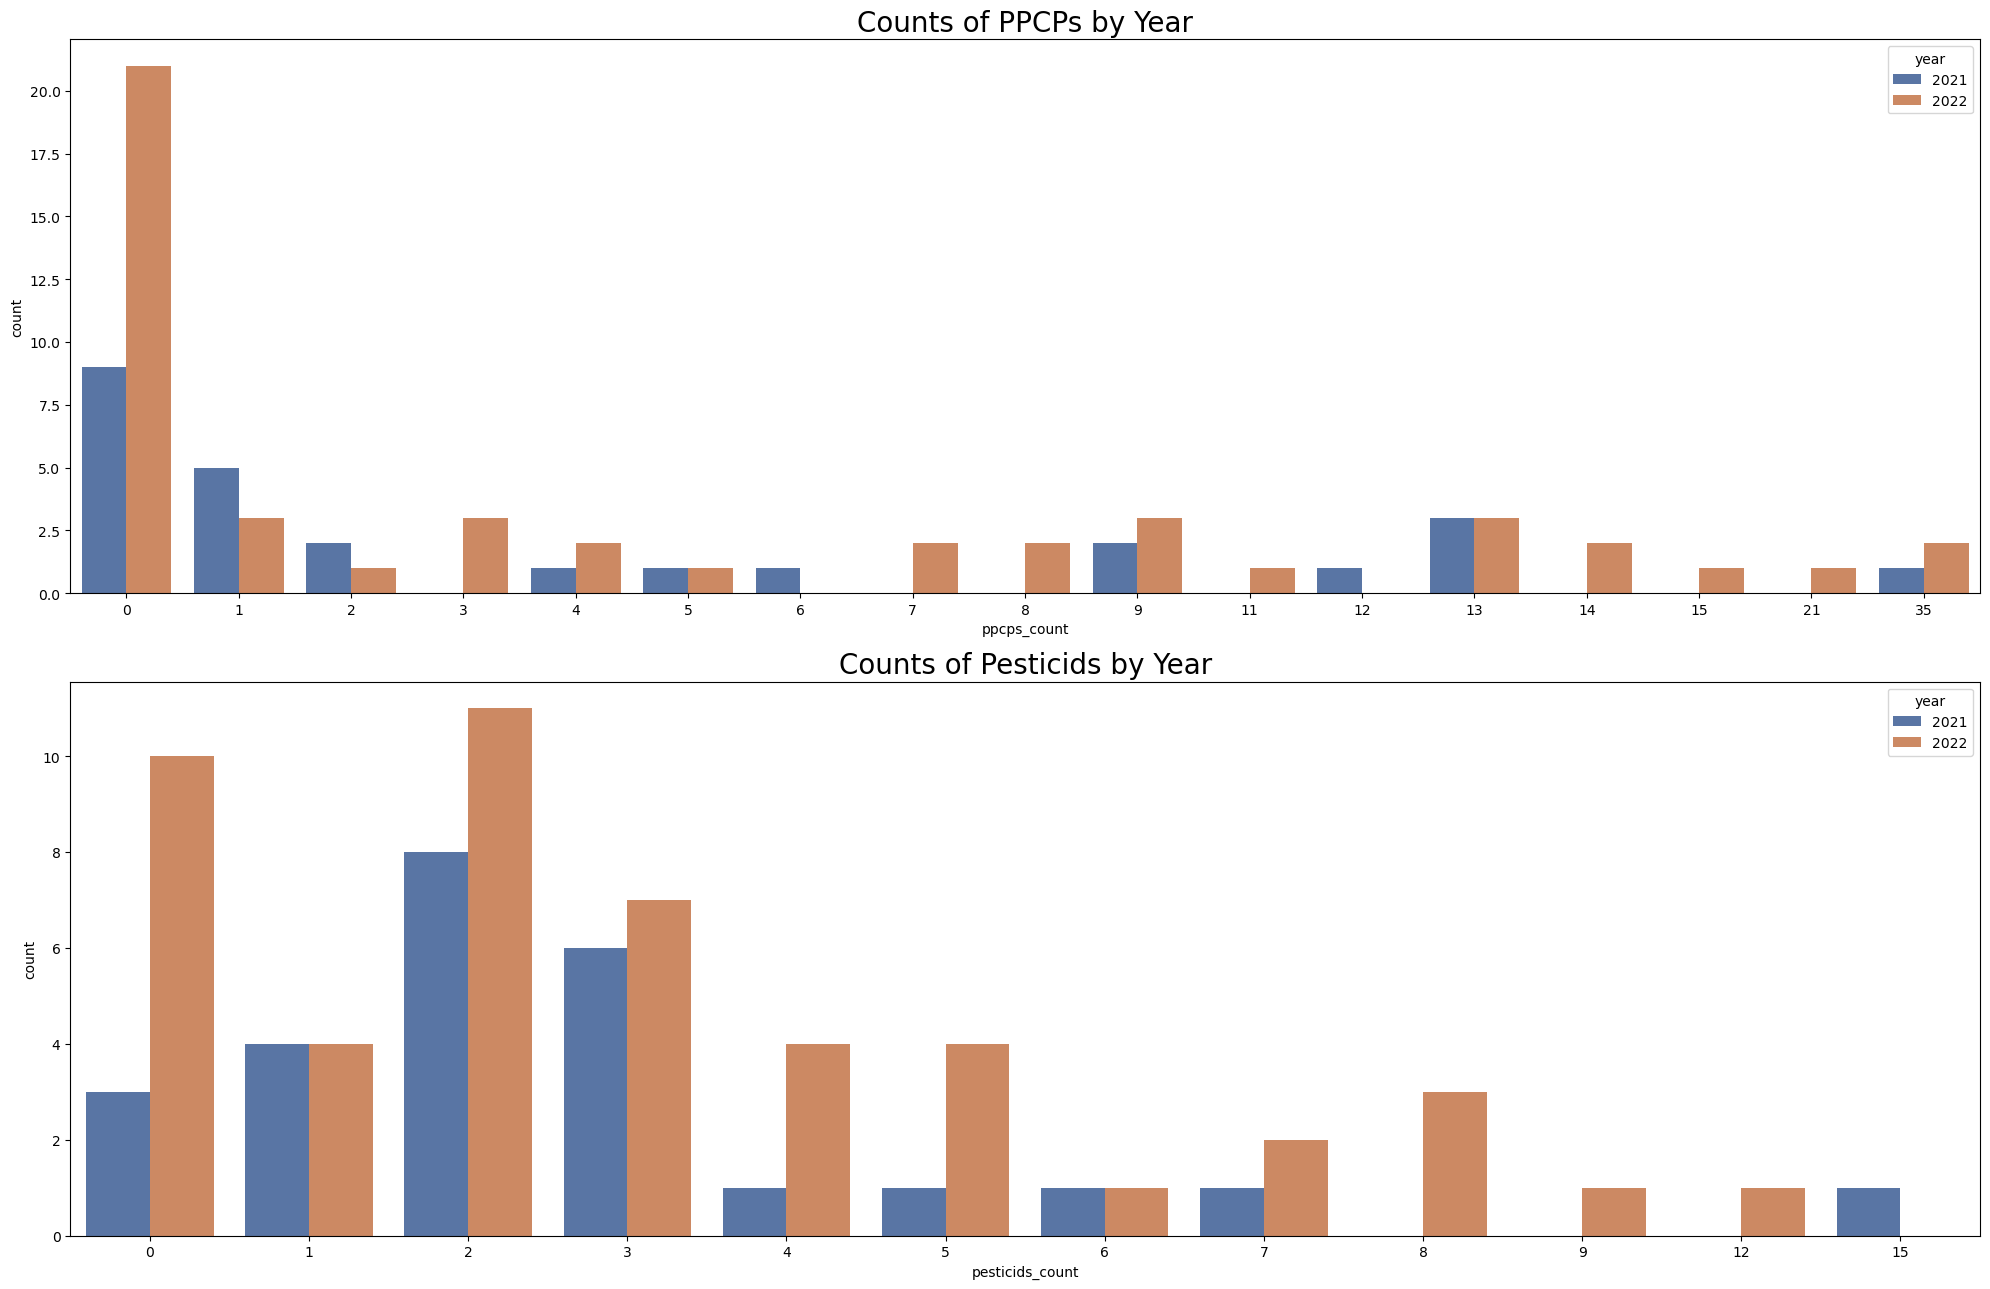

In [23]:
# Visualize counts distributions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 13))
sns.countplot(data=data2, x="ppcps_count", hue="year", ax=axes[0], palette="deep")
sns.countplot(data=data2, x="pesticids_count", hue="year", ax=axes[1], palette="deep")
axes[1].set_title("Counts of Pesticids by Year", fontsize=20)
axes[0].set_title("Counts of PPCPs by Year", fontsize=20)

plt.tight_layout()
plt.show()

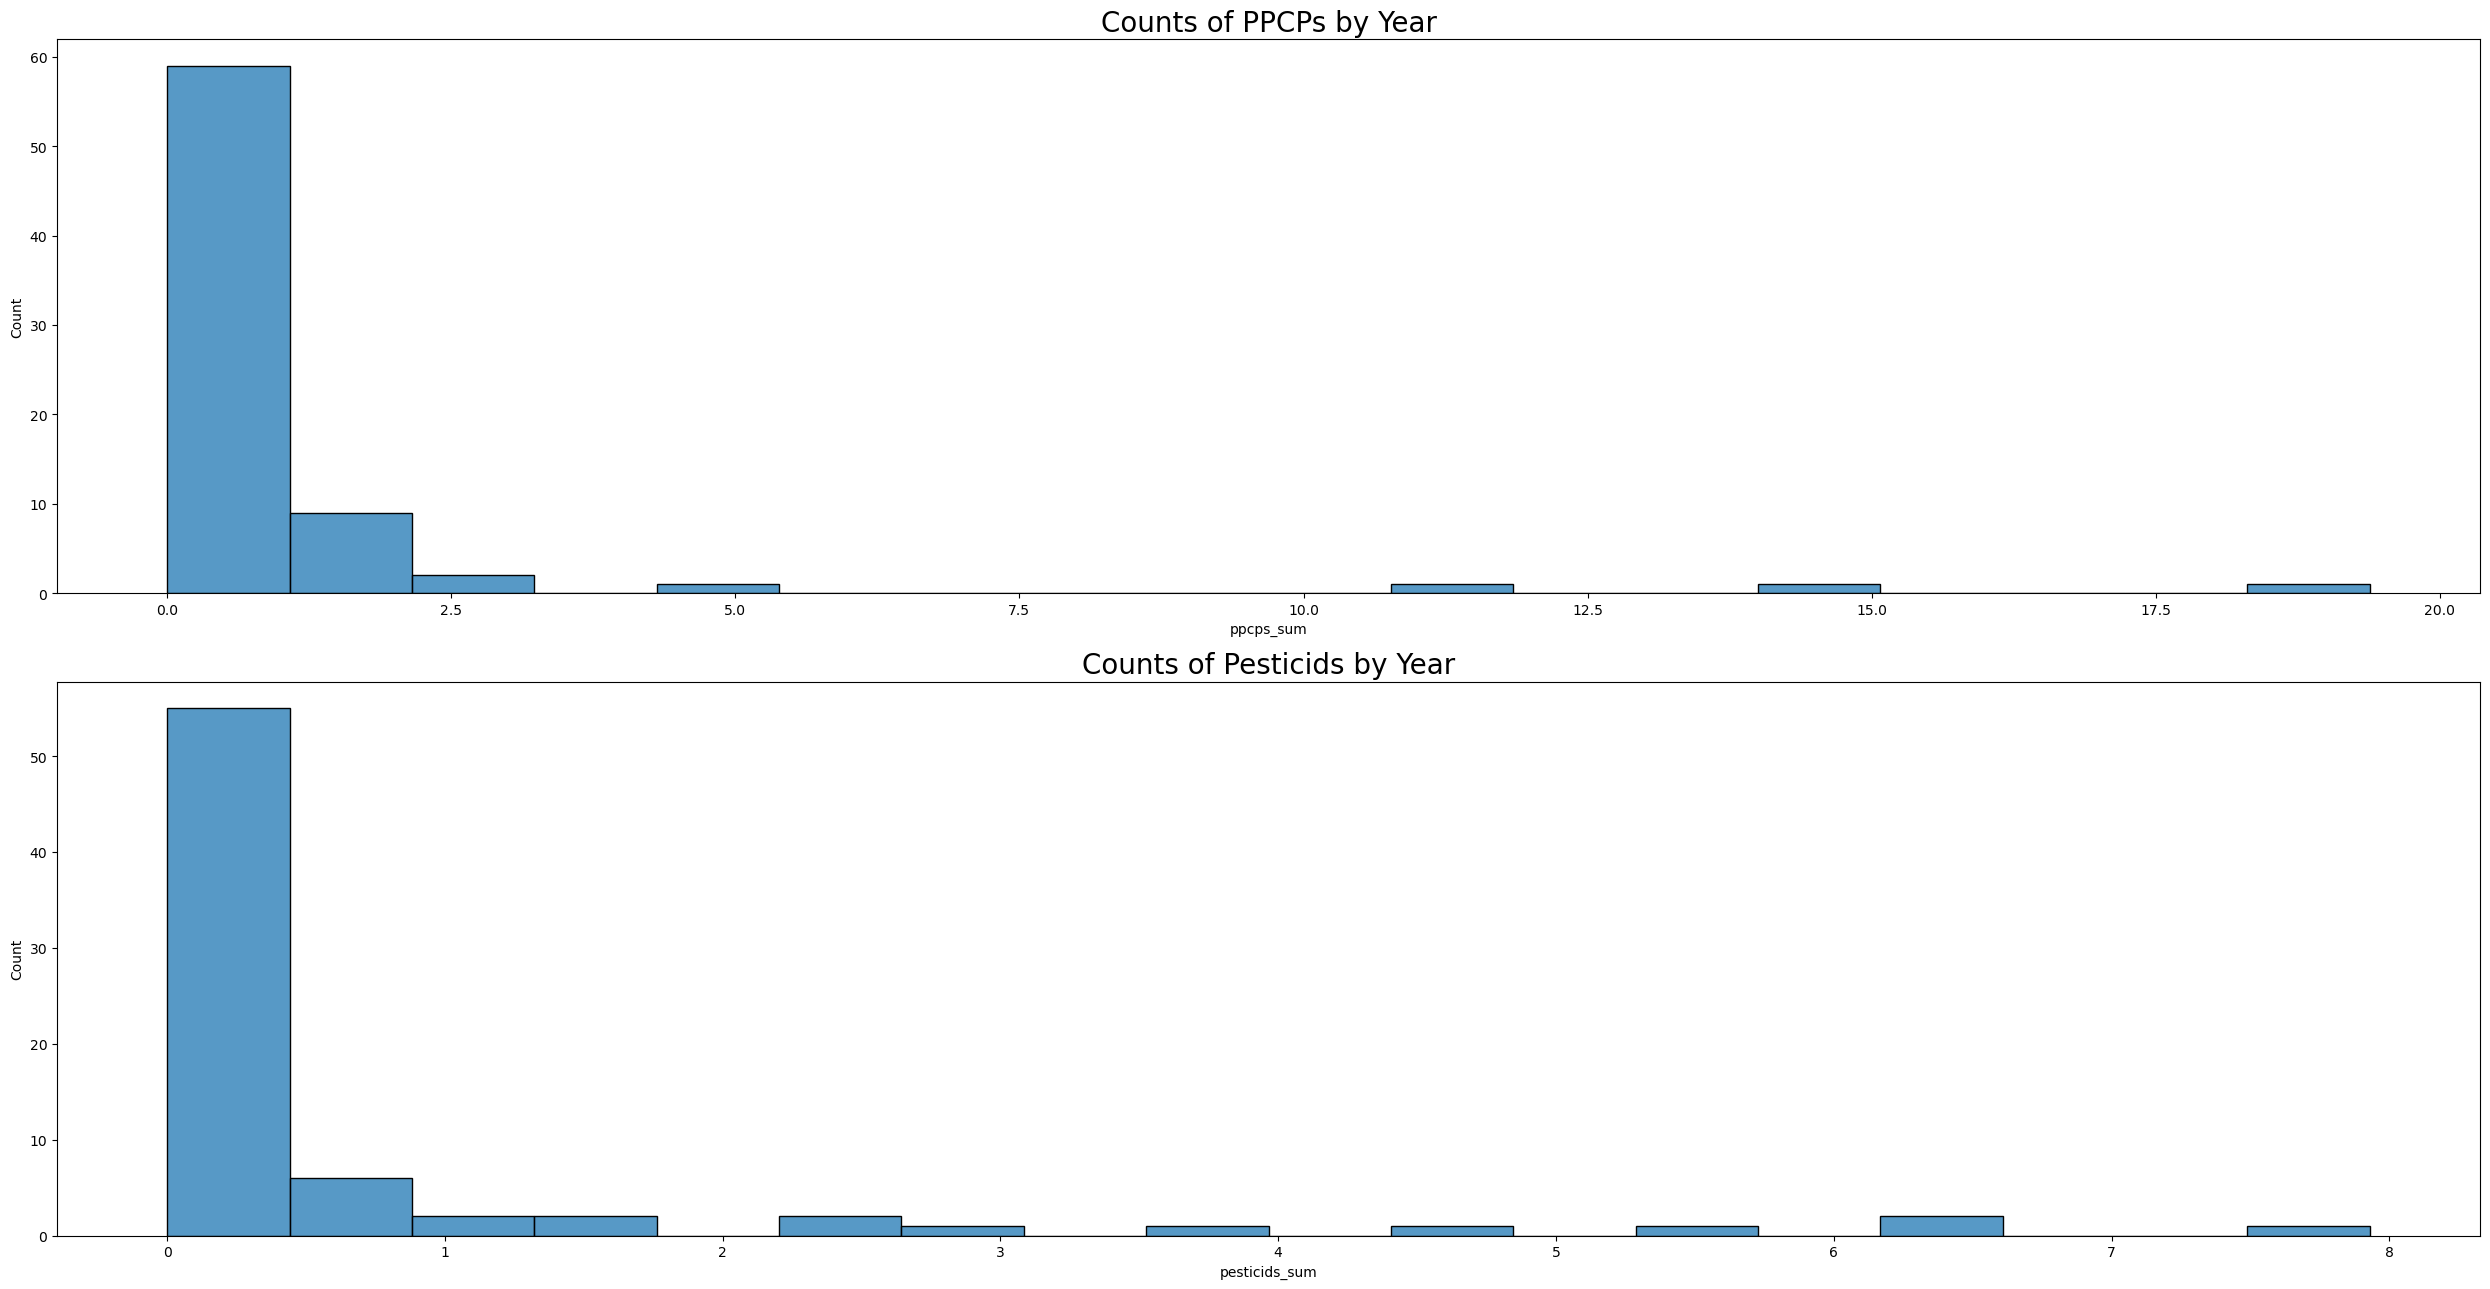

In [24]:
# Visualize sum distributions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 13))
sns.histplot(data=data2, x="ppcps_sum", ax=axes[0])
sns.histplot(data=data2, x="pesticids_sum", ax=axes[1])
axes[0].set_title("Counts of PPCPs by Year", fontsize=20)
axes[1].set_title("Counts of Pesticids by Year", fontsize=20)
plt.tight_layout()
plt.show()

In [25]:
data2.groupby(["year"])["site_id"].value_counts()


year  site_id
2021  BUR3       2
      EGE2       2
      EGE3       2
      NYU2       2
      RV         2
      S2         2
      TAP1       2
      TAP2       2
      TAP3       2
      EGE6       1
      LES3       1
      MV23       1
      MV32       1
      NYU1       1
      POG9       1
      S1A        1
      ZALA1      1
2022  EGE2       3
      EGE3       3
      EGE4       3
      EGE5       3
      EGE6       3
      NYU1       3
      NYU2       3
      RV         3
      S2         3
      TAP1       3
      TAP2       3
      TAP3       3
      MV23       2
      ZALA1      2
      BUR2       1
      BUR3       1
      F1         1
      KET3       1
      LES3       1
      MV32       1
      POG9       1
      ÖRV1       1
Name: count, dtype: int64

In [26]:
data2["site_id"].value_counts()

site_id
TAP3     5
TAP2     5
EGE2     5
EGE3     5
TAP1     5
S2       5
RV       5
NYU2     5
NYU1     4
EGE6     4
MV23     3
ZALA1    3
EGE5     3
EGE4     3
BUR3     3
MV32     2
POG9     2
LES3     2
KET3     1
ÖRV1     1
F1       1
S1A      1
BUR2     1
Name: count, dtype: int64

In [27]:
zero_ids = data2[(data2["ppcps_count"] == 0) & (data2["pesticids_count"] == 0)]

In [28]:
print("Number of sampling sites without any PPCPs or Pesticids:", len(zero_ids))

Number of sampling sites without any PPCPs or Pesticids: 8


In [29]:
print("Percent of sites with 0 ppcps and pesticides: ", np.round(((len(zero_ids) / len(data2)) * 100), 2), "%")

Percent of sites with 0 ppcps and pesticides:  10.81 %


In [30]:
for row in zero_ids.itertuples():
    print(f"{row.site_id} - {row.location} ({row.year})")

MV23 - D (2021)
MV23 - D (2022)
BUR2 - É (2022)
BUR3 - É (2022)
EGE4 - É (2022)
EGE4 - É (2022)
LES3 - É (2022)
ÖRV1 - É (2022)


In [31]:
data2["site_id"].value_counts() 

site_id
TAP3     5
TAP2     5
EGE2     5
EGE3     5
TAP1     5
S2       5
RV       5
NYU2     5
NYU1     4
EGE6     4
MV23     3
ZALA1    3
EGE5     3
EGE4     3
BUR3     3
MV32     2
POG9     2
LES3     2
KET3     1
ÖRV1     1
F1       1
S1A      1
BUR2     1
Name: count, dtype: int64

In [32]:
data2["year"].value_counts()

year
2022    48
2021    26
Name: count, dtype: int64

In [33]:
print("Measurements in 2021: ", len(data2[data2["year"] == 2021]))
print("Measurements in 2022: ", len(data2[data2["year"] == 2022]))

Measurements in 2021:  26
Measurements in 2022:  48


In [34]:
print("Unique sites in 2021: ", len(data2[data2["year"] == 2021]["site_id"].unique()))
print("Unique sites in 2022: ", len(data2[data2["year"] == 2022]["site_id"].unique()))

Unique sites in 2021:  17
Unique sites in 2022:  22


In [35]:
data2[data2["site_id"] == "EGE2"]

,site_id,sampling_date,location,year,ppcps_count,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,Bikalutamid 1,...,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1,ppcps_sum,pesticids_sum
9,EGE2,2021-06-29,É,2021,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.15
10,EGE2,2021-09-08,É,2021,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.027,0.18
11,EGE2,2022-07-04,É,2022,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030,0.08
12,EGE2,2022-07-27,É,2022,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.08
13,EGE2,2022-08-30,É,2022,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.09


### A következő lépések előtt pár dolgot át kell gondolni:
1. Mivel változó, hogy évente hány mérés volt pontonként, és mondjuk az Észak vs Délt akarom összehasonlítani, ha átlagot számolok ezekből, akkor azok a pontok, ahol több mérés is volt nagyobb súllyal esnek bele az átlagszámításba. Például tegyük fel, hogy az egyik helyen (P1) egy mérés volt és mértetek 0.12-es koncentrációt, míg a másikon (P2) volt négy, amik kb. 0.25 és 0.27 között mozogtak. Akkor a csoporton belüli aggregálás során a P1 csak egyszer, míg a P2 négyszer fog latba esni, és elnyomja - valótlanul - az átlagot. Pedig ha ezt a példát jobban megnézi az ember, kb ugyanazt az érték körül mozog a P2 mind a négy mérés során, tehát ugynazt mérhettétek. Ezért ahol több mérés volt, ott célszerű a több mérést még a stat számolás előtt összevonni egy értékké. Mondjuk átlagot számolva belőlük, így a P4-en is csak egy adatsor lesz, aminek az értéke 0.26. Így ugyazzal az egymáshoz viszonyított súlyozással számolhatunk.

2. A második probléma, hogyha megpróbálom a szummált koncentráció értékeket összevonni, mondjuk a P2 esetében és tegyük fel az első mérés 0 volt és a többi 0.25 és 0.26 közé esett, akkor az a 0 el fogja nyomni az átlagot. Pedig könnyen lehet, hogy az első mérésnél azért jött ki 0, mert más PPCP-ket mértetek, mint a többi 3-nál. Nem néztem utána, hogy ilyen helyzet van-e és valóban azért van, mert mások voltak a mért PPCP-k. Itt azt lehet csinálni, hogy ahol 0 van a szummált értéknél, azt átalakítani NaN-ná és akkor nem veszi bele az átlagolásba (esetleg droppolni, ha a stat tilatokzik ellene).

3. Illetve, hogy egyszerűsítsük a helyzetet, tegyük fel, hogy a P2-n nem úgy voltak a pontos mérési időpontok, hogy 2021-ben januárban volt az első, márciusban a második, júniusban a harmadik és decemberben a negyedik, majd 2022-ben csak egy mérés volt, de az januárban. Mert akkor ugye a 2021 decemberi közelebb áll a 2022 januári méréshez, mint a 2021 januárihoz. Szóval, ettől inkább tekintsünk most el, mert megbonyolítaná a helyzetet. De ha mondjuk publikálni akarnád az eredményeket, akkor ezzel is foglalkozni kellene.   

4. Nehezíti még az összehasonlítást, hogy nem egyenlőek a csoportelemszámok, 2021-ben csak 25 mérés volt, míg 2022-ben 41. Ezt majd a nem-parametrikus stat kezeli elvileg. Összehasonlítottam, kb ugyanannyi ponton mértetek mindkét évben (2021: 16, 2022: 18), viszont 2022-ben többször mértetek egy-egy pontot. Van olyan pont, amit csak összesen egyszer mértetek és lehet olyan is, hogy mondjuk 2-szer mértétek 2022-ben, de egyszer sem 2021-ben. Ez még lehet problémás, de most az egyszeűség kedvéért tekintsünk el tőle, úgysem az egyes mérési pontok változását hasonlítjuk össze, hanem csak a két év összesített értékeit. Talán még kevésbé gond, ha a vízgyűjtő területek hasonlítjuk össze.

In [37]:
data2["ppcps_count"].describe()

count    74.000000
mean      5.351351
std       8.028088
min       0.000000
25%       0.000000
50%       1.000000
75%       9.000000
max      35.000000
Name: ppcps_count, dtype: float64

In [38]:
data2[data2["site_id"] == "S2"]

,site_id,sampling_date,location,year,ppcps_count,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,Bikalutamid 1,...,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1,ppcps_sum,pesticids_sum
51,S2,2021-06-29,D,2021,35,0.000,0.0,0.17,0.011,0.04,...,0.0,0.06,0.0,0.00,0.02,0.06,0.78,0.03,19.384,7.93
52,S2,2021-09-08,D,2021,1,0.000,NaN,0.00,0.000,0.00,...,0.0,0.00,0.0,0.02,0.00,0.00,0.00,0.00,0.050,0.22
53,S2,2022-07-04,D,2022,7,0.000,0.0,0.00,0.000,0.00,...,0.0,0.00,0.0,0.00,0.02,0.02,0.01,0.09,0.787,6.31
54,S2,2022-07-22,D,2022,35,0.011,0.0,0.66,0.000,0.03,...,0.0,0.00,0.0,0.00,0.00,0.04,0.00,0.02,14.810,5.57
55,S2,2022-08-30,D,2022,35,0.012,NaN,0.24,0.000,0.03,...,0.0,0.00,0.0,0.00,0.00,0.01,0.00,0.01,11.841,6.26


Ez így enem okés, mert idx.51-nél 35 a count, idx.52 meg 1, valószínűleg azért mert valamit rámértek, olyat, ami az első körben nem volt, így komplementer a két kör. Nem átlagolhatom össze a 35-öt meg az 1-et.

Megint megnézve egyébként nem...nem tudom mi történt ott, hogy júniusban egy csomó minden határérték felett volt, szeptemberre meg aláment. Mit lehet ezzel csinálni?

Első körben legyen az a megoldás, hogy átlagot számolok. Ha 0 az érték akkor is oké, legalább jelzi, hogy egy éven belül mekkora változás volt. Ha NaN, akkor pedig nem veszi figyelembe az aggregálásnál. A count adatnál pedig maximumot, mert az nehezen értelmezhető, hogy egyszer 35 mért pozitív adat van utána meg kétszer 0 és az átlaguk csak 11.5, elég erős szezonalitás figyelhető meg. Hozzáadom a mérés pontos időpontját is és akkor a max érték lesz összehasonlítva minden évben.  

## Creating count data

In [41]:
# Create dataframes whith aggregated (max) count values for ppcps and pestcids
data3 = data2.copy()

# Get the index of the maximum ppcps_count for each site and year
ppcp_max_idx = data3.groupby(["site_id", "year"])["ppcps_count"].idxmax().reset_index()

# Extract the rows with the maximum ppcps_count
ppcps_count = data3.loc[ppcp_max_idx["ppcps_count"], ["site_id", "year", "sampling_date", "ppcps_count", "location"]]

# Get the index of the maximum pesticids_Count for each site and year
pesticids_max_idx = data3.groupby(["site_id", "year"])["pesticids_count"].idxmax().reset_index()

# Extract the rows with the maximum pesticids_count
pesticids_count = data3.loc[pesticids_max_idx["pesticids_count"], ["site_id", "year", "sampling_date", "pesticids_count", "location"]]




In [42]:
# Check if the sampling dates are the same for both datasets
ppcps_count["sampling_date"].equals(pesticids_count["sampling_date"])

False

In [43]:
# Get the lengths of each resulting dfs:
print("Max pesticids dataframe length: ", len(pesticids_count)) 
print("Max ppcps dataframe length: ", len(ppcps_count))

Max pesticids dataframe length:  39
Max ppcps dataframe length:  39


In [44]:
# Calculate the difference between the sampling dates
diff_mask = ppcps_count["sampling_date"].values != pesticids_count["sampling_date"].values
print("Number of different sampling dates: ", diff_mask.sum())

Number of different sampling dates:  8


In [45]:
ppcps_count["ppcps_count"].describe()

count    39.000000
mean      6.820513
std       8.768580
min       0.000000
25%       0.000000
50%       3.000000
75%      12.500000
max      35.000000
Name: ppcps_count, dtype: float64

In [46]:
pesticids_count["pesticids_count"].describe()

count    39.000000
mean      3.102564
std       3.314997
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      15.000000
Name: pesticids_count, dtype: float64

In [47]:
ppcps_count.head()

,site_id,year,sampling_date,ppcps_count,location
5,BUR2,2022,2022-07-04,0,É
6,BUR3,2021,2021-06-29,2,É
8,BUR3,2022,2022-07-04,0,É
10,EGE2,2021,2021-09-08,12,É
11,EGE2,2022,2022-07-04,2,É


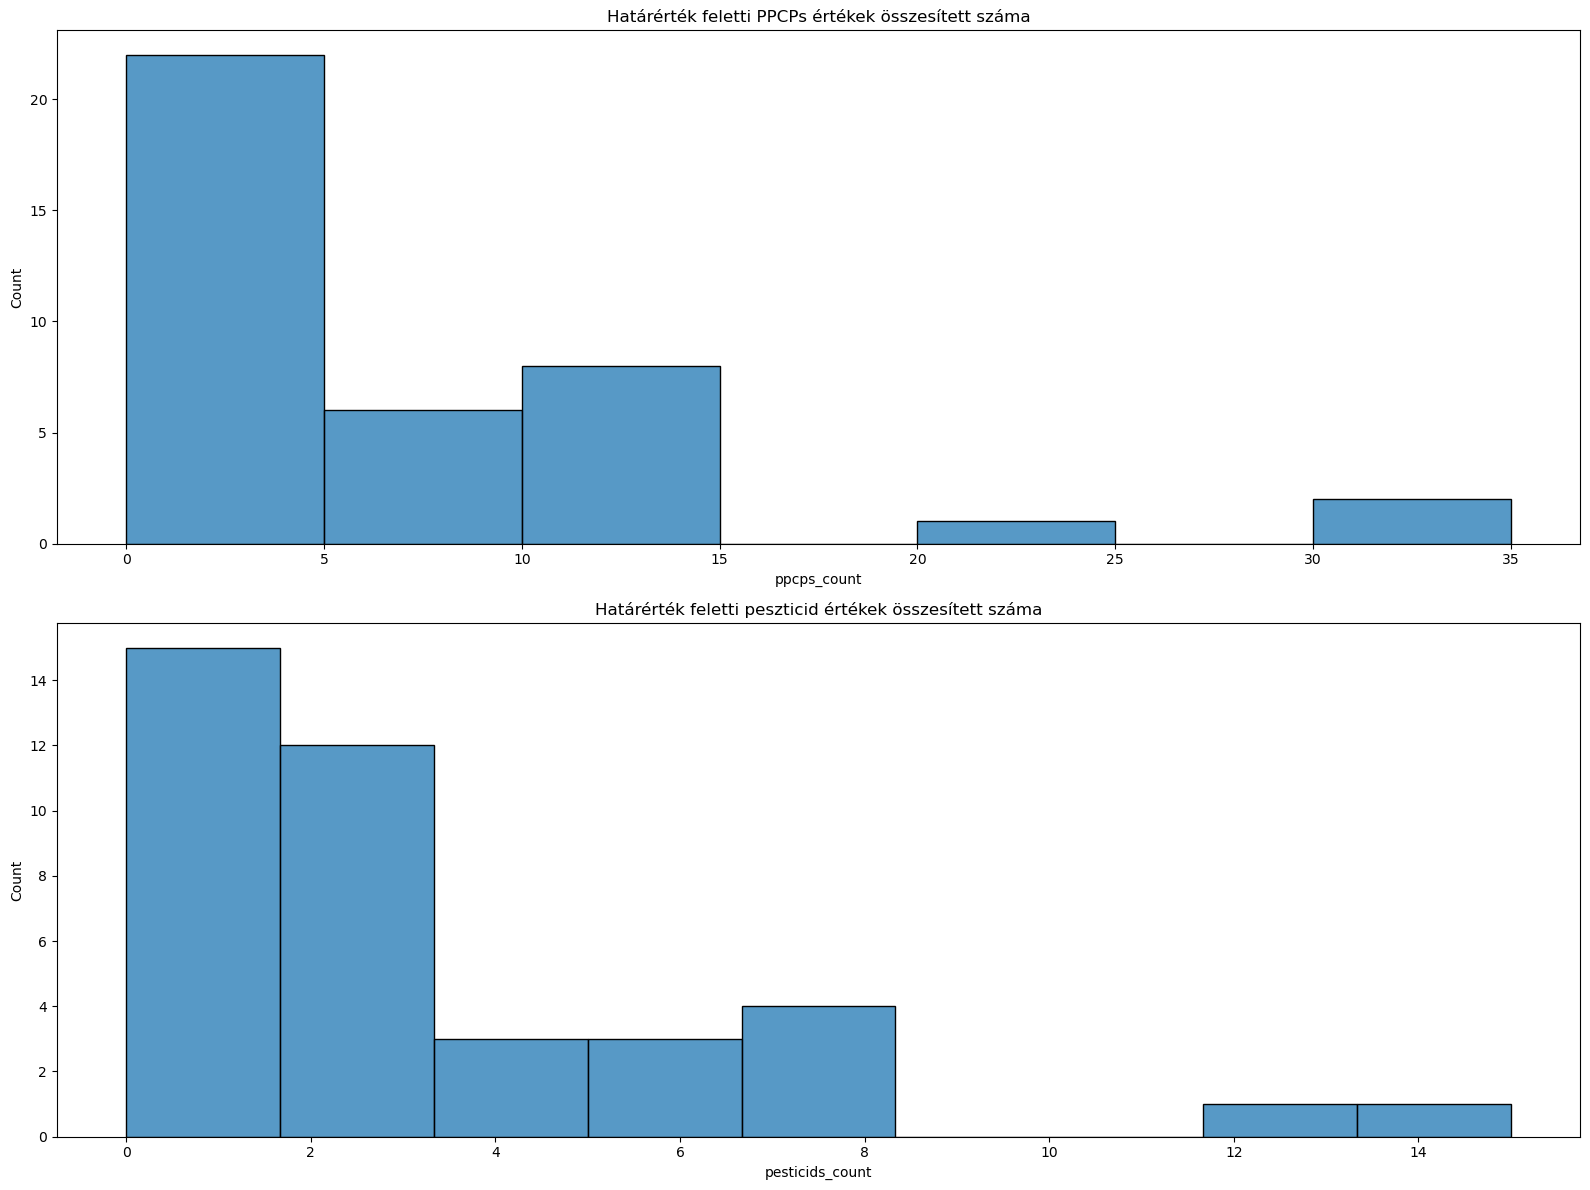

In [48]:
# Visualize distributions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
sns.histplot(ppcps_count["ppcps_count"], ax=axes[0])
axes[0].set_title("Határérték feletti PPCPs értékek összesített száma")
sns.histplot(pesticids_count["pesticids_count"], ax=axes[1])
axes[1].set_title("Határérték feletti peszticid értékek összesített száma")
plt.tight_layout()
plt.show()



## Creating sum data

In [49]:
data2[["ppcps_sum", "pesticids_sum"]].describe()

,ppcps_sum,pesticids_sum
count,74.000000,74.000000
mean,1.054243,0.762838
std,3.127303,1.638725
min,0.000000,0.000000
25%,0.000000,0.030000
50%,0.036000,0.095000
75%,0.698500,0.445000
max,19.384000,7.930000


Mediánt fogok számolni a szélsőségesebb értékek és a szezonalitás miatt. Először próbáljuk meg évre és vízgyűjtőre is csoportosítani, hátha tudunk valamilyen nem-parametrikus kevert modelt futtatni. Ha nem megy, akkor létrehozunk külön-külön adattáblát nekik.

In [50]:
# Get median values grouped by site, year and location
ppcps_sum = data3.groupby(["site_id", "year", "location"])["ppcps_sum"].median().reset_index()

# Get the index of the maximum pesticids_Count for each site and year
pesticids_sum = data3.groupby(["site_id", "year", "location"])["pesticids_sum"].median().reset_index()


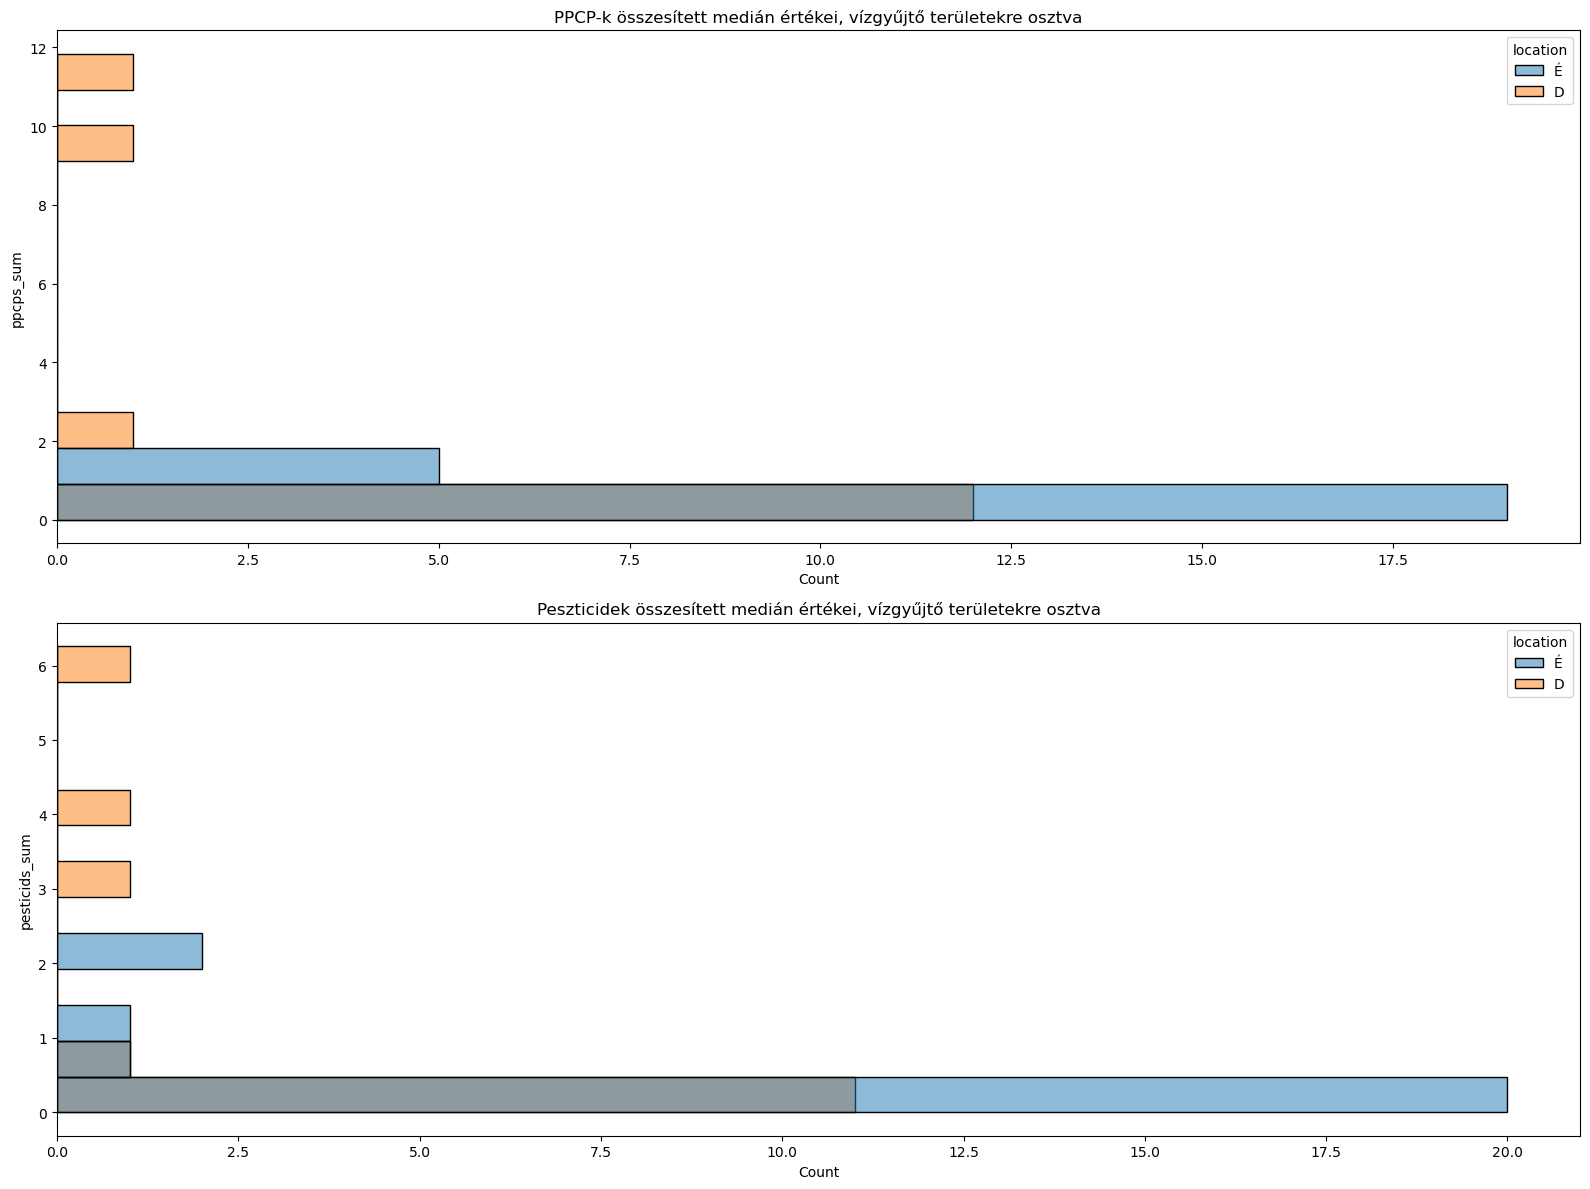

In [51]:
# Visualize distributions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
sns.histplot(ppcps_sum, y="ppcps_sum", hue="location", ax=axes[0])
axes[0].set_title("PPCP-k összesített medián értékei, vízgyűjtő területekre osztva")
sns.histplot(pesticids_sum, y="pesticids_sum", hue="location", ax=axes[1])
axes[1].set_title("Peszticidek összesített medián értékei, vízgyűjtő területekre osztva")
plt.tight_layout()
plt.show()

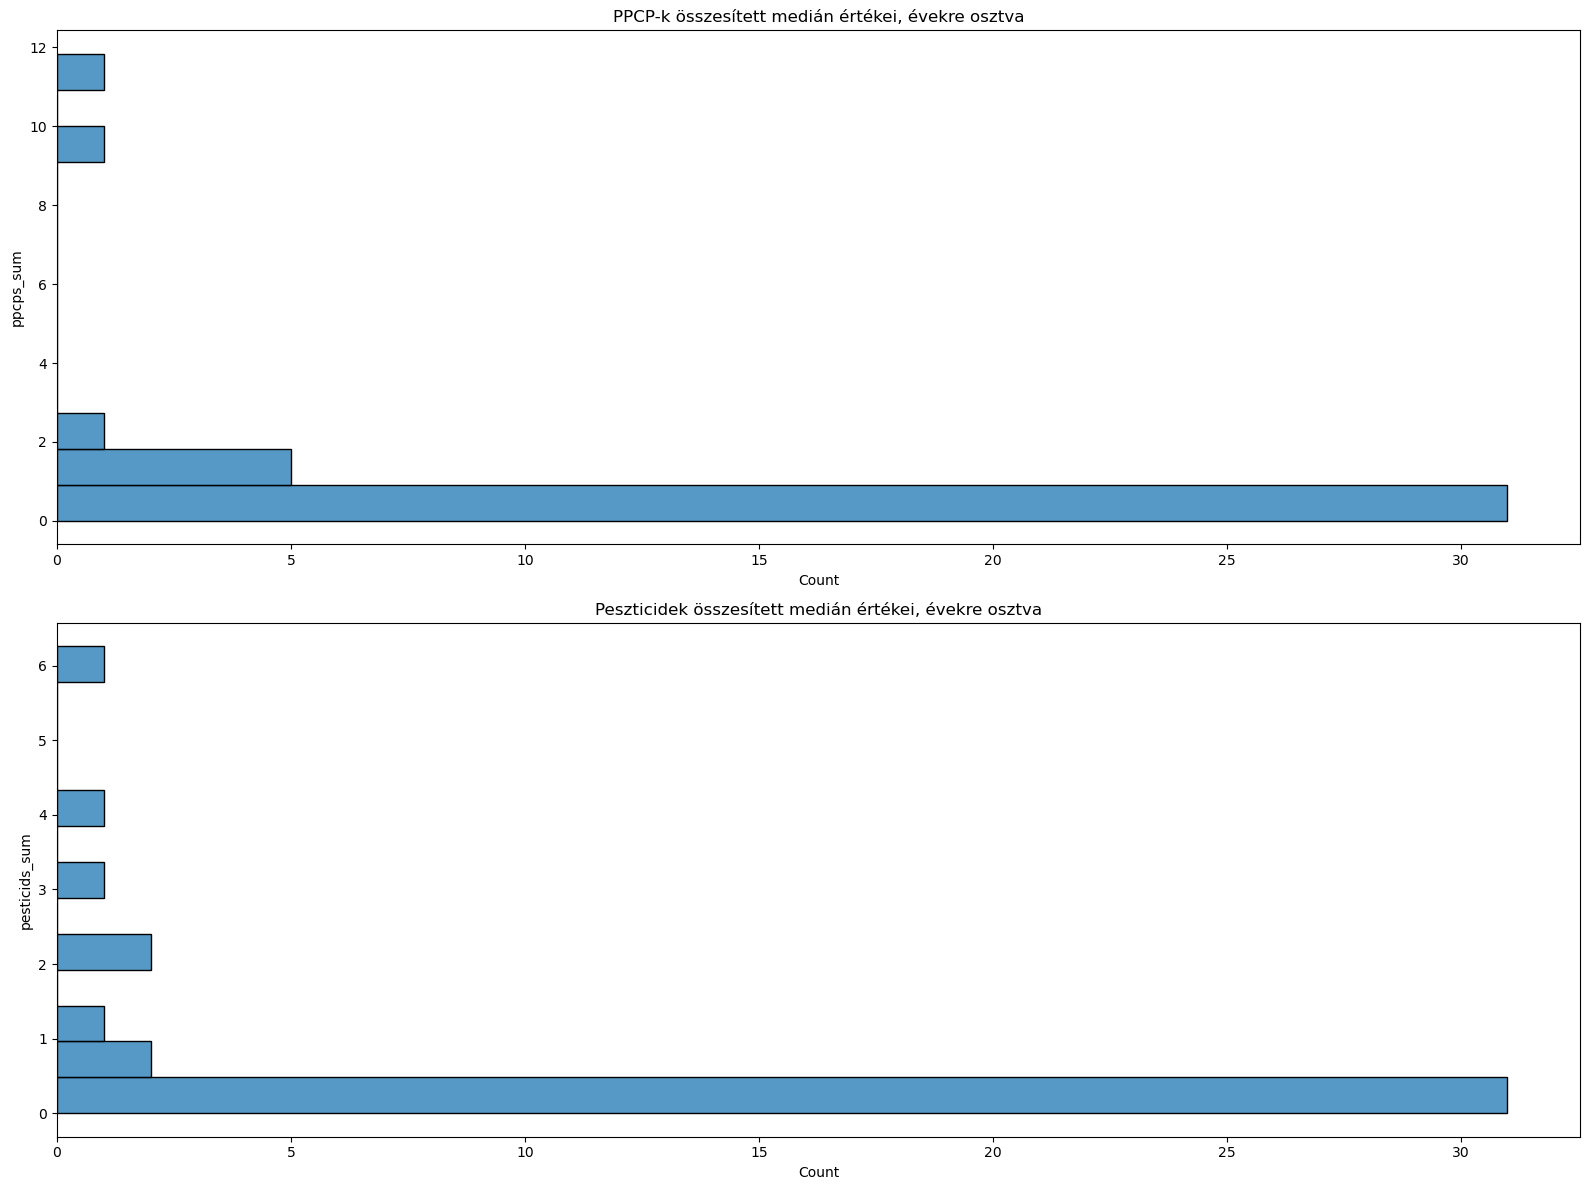

In [71]:
# Visualize distributions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
sns.histplot(ppcps_sum, y="ppcps_sum", ax=axes[0])
axes[0].set_title("PPCP-k összesített medián értékei, évekre osztva")
sns.histplot(pesticids_sum, y="pesticids_sum", ax=axes[1])
axes[1].set_title("Peszticidek összesített medián értékei, évekre osztva")
plt.tight_layout()
plt.show()

Ebből nem sok mindent tudtunk megállapítani, max csak annyit, hogy ebből nem nagyon lesz normál eloszlás, inkább hasonlít Poissonra.

## Analysis

### Count data

Khí-négyzet teszt lenne a legegyszerűbb, de:
- a tiéd az jellemzően sparse adata szerintem, sok benne a nulla (ez talán a környezet szempontjából jó is:))
- nem képes kezelni az összetartozó mintát, tehát 2021 vs 2022

környezeti adat modellezése és elemzése:
- https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.13559?utm_source=chatgpt.
- ld. még: https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Zero-Inflated_Negative_Binomial_Regression.pdf

In [58]:
print("Mean: ", np.mean(ppcps_count["ppcps_count"]))
print("Variance: ", np.var(ppcps_count["ppcps_count"]))

Mean:  6.82051282051282
Variance:  74.91650230111769


In [70]:
zeros = np.round((len(ppcps_count[ppcps_count["ppcps_count"] == 0]) / len(ppcps_count) * 100), 2)
print("A 0 értékek aránya a teljes adasorhoz képest: ", zeros)

A 0 értékek aránya a teljes adasorhoz képest:  30.77


Itt most kellene tesztelni, hogy zero-inflated-e az adat, illeszteni egy poisson regressziót és abból kiszámolni, ehhez nem értek, az egyszerűség kedvéért maradjunk annyiban, hogy szerintem sok a nulla = sparse az adat, tehát zero-inflated. Futtatjuk a koonzervatívabb tesztet.

#### A fent idézett cikk alapján: feltételezzük, hogy sparse adatról van szó, a sok nulla miatt és overdispersed, tehát a variancia kb. 11-szerese az átlagnak (a kb. egyenlő helyett), ezért egy zero-inflated negative binomial modellt kell alkalmazzunk.

A fenti cikk alapján:
- ϕ (phi): diszperzió paraméter
    - ϕ = ∞: nincs overdispersion
    - ϕ < ∞: overdispersion van
- ω (omega): zero-inflation paraméter
    - ω = 0: nincs zero-inflation
    - ω > 0: zero-inflation van


1. scenarios with ϕ = ∞ and ω = 0 as those with data simulated from the Poisson distribution;
2. scenarios with ϕ < ∞ and ω = 0 as those with data simulated from the negative binomial distribution;
3. scenarios with ϕ = ∞ and ω > 0 as those with data simulated from the zero-inflated Poisson distribution; and
4. scenarios with ϕ < ∞ and ω > 0 as those with data simulated from the zero-inflated negative binomial distribution.

### Analyzing PPCPs' count

In [80]:
ppcps_count[["year", "location"]] = ppcps_count[["year", "location"]].astype("category")

ppcps_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 5 to 42
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   site_id        39 non-null     object        
 1   year           39 non-null     category      
 2   sampling_date  39 non-null     datetime64[ns]
 3   ppcps_count    39 non-null     int64         
 4   location       39 non-null     category      
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 1.5+ KB


In [92]:

infl_formula_ppcps1 = "year * location"

exog_infl_ppcps1 = patsy.dmatrix(infl_formula_ppcps1 + " - 1", ppcps_count, return_type='dataframe')


In [93]:
ppcp_model_zinb1 = ZeroInflatedNegativeBinomialP.from_formula(
    "ppcps_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=exog_infl_ppcps1, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=ppcps_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

ppcp_model_zinb1.summary()

Optimization terminated successfully.
         Current function value: 2.779995
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                       ppcps_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 17 Jul 2025   Pseudo R-squ.:                 0.02680
Time:                                   23:28:44   Log-Likelihood:                -108.42
converged:                                  True   LL-Null:                       -111.41
Covariance Type:                       nonrobust   LLR p-value:                    0.1130
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
inflate_year[2021]                    -0.6950      0.840     -0.827      0.408      -2.342       0.952
inflate_year[2022]                   -14.0090    416.363     -0.034      0.973    -830.065     802.047
inflate_location[T.É]                 -0.2895      1.209     -0.240      0.811      -2.658       2.079
inflate_year[T.2022]:location[T.É]    13.5940    416.365      0.033      0.974    -802.466     829.654
Intercept                              2.4029      0.437      5.494      0.000       1.546       3.260
year[T.2022]                           0.0701      0.569      0.123      0.902      -1.046       1.186
location[T.É]                         -0.2753      0.593     -0.464      0.643      -1.438       0.887
year[T.2022]:location[T.É]            -0.2700      0.774     -0.349      0.727      -1.787       1.247
alpha                                  0.8455      0.331      2.551      0.011       0.196       1.495
======================================================================================================
"""

Nincs szignifikáns különbség, egyedül az alpha érték, ami elvileg azt jelzi, hogy valóban overdispersed az adat.

In [94]:
infl_formula_ppcps2 = "location"

exog_infl_ppcps2 = patsy.dmatrix(infl_formula_ppcps2 + " - 1", ppcps_count, return_type='dataframe')

In [95]:
ppcp_model_zinb2 = ZeroInflatedNegativeBinomialP.from_formula(
    "ppcps_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=exog_infl_ppcps2, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=ppcps_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

ppcp_model_zinb2.summary()

Optimization terminated successfully.
         Current function value: 2.822678
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                       ppcps_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 17 Jul 2025   Pseudo R-squ.:                 0.01186
Time:                                   23:30:49   Log-Likelihood:                -110.08
converged:                                  True   LL-Null:                       -111.41
Covariance Type:                       nonrobust   LLR p-value:                    0.4500
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_location[D]           -2.1435      1.688     -1.270      0.204      -5.451       1.164
inflate_location[É]           -0.9502      0.704     -1.350      0.177      -2.330       0.429
Intercept                      2.2172      0.533      4.158      0.000       1.172       3.262
year[T.2022]                   0.2557      0.669      0.382      0.702      -1.055       1.567
location[T.É]                 -0.1114      0.664     -0.168      0.867      -1.413       1.190
year[T.2022]:location[T.É]    -0.4894      0.881     -0.555      0.579      -2.216       1.238
alpha                          1.0574      0.561      1.885      0.059      -0.042       2.157
==============================================================================================
"""

ismét semmi eredmény

In [96]:
infl_formula_ppcps3 = "year"

exog_infl_ppcps3 = patsy.dmatrix(infl_formula_ppcps3 + " - 1", ppcps_count, return_type='dataframe')


ppcp_model_zinb3 = ZeroInflatedNegativeBinomialP.from_formula(
    "ppcps_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=exog_infl_ppcps3, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=ppcps_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

ppcp_model_zinb3.summary()

Optimization terminated successfully.
         Current function value: 2.827320
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                       ppcps_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 17 Jul 2025   Pseudo R-squ.:                 0.01024
Time:                                   23:31:54   Log-Likelihood:                -110.27
converged:                                  True   LL-Null:                       -111.41
Covariance Type:                       nonrobust   LLR p-value:                    0.5162
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_year[2021]            -1.0220      0.819     -1.248      0.212      -2.627       0.583
inflate_year[2022]            -2.0198      1.851     -1.091      0.275      -5.647       1.607
Intercept                      2.3379      0.508      4.599      0.000       1.341       3.334
year[T.2022]                   0.1351      0.660      0.205      0.838      -1.158       1.428
location[T.É]                 -0.2483      0.663     -0.375      0.708      -1.547       1.050
year[T.2022]:location[T.É]    -0.5101      0.913     -0.559      0.576      -2.300       1.279
alpha                          1.1535      0.664      1.738      0.082      -0.148       2.455
==============================================================================================
"""

itt még az alpha sem lett szignifikáns

In [101]:
models = [ppcp_model_zinb1, ppcp_model_zinb2, ppcp_model_zinb3]

results_list = []

for i, model in enumerate(models, 1):
    results_list.append({
        "model": f"ppcp_model_zinb{i}",
        "llf": model.llf,
        "aic": model.aic,
        "bic": model.bic
    })

results = pd.DataFrame(results_list)
print(results)

              model         llf         aic         bic
0  ppcp_model_zinb1 -108.419804  234.839608  249.811663
1  ppcp_model_zinb2 -110.084455  234.168910  245.813842
2  ppcp_model_zinb3 -110.265462  234.530923  246.175855


In [102]:
ppcps_count.groupby(['year', 'location'])['ppcps_count'].agg(['count', lambda x: (x==0).sum()])


C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_2768\1052090563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppcps_count.groupby(['year', 'location'])['ppcps_count'].agg(['count', lambda x: (x==0).sum()])


count  <lambda_0>
year location                   
2021 D             8           3
     É             9           3
2022 D             7           0
     É            15           6

In [ ]:
ppcp_model_zinb1.predict(which="prob-zero")


array([0.40000846, 0.33334916, 0.40000846, 0.33334916, 0.40000846,
       0.33334916, 0.40000846, 0.40000846, 0.40000846, 0.33334916,
       0.40000846, 0.40000846, 0.40000846, 0.33334916, 0.40000846,
       0.37499124, 0.05850191, 0.37499124, 0.05850191, 0.37499124,
       0.05850191, 0.37499124, 0.05850191, 0.37499124, 0.05850191,
       0.33334916, 0.40000846, 0.37499124, 0.37499124, 0.05850191,
       0.33334916, 0.40000846, 0.33334916, 0.40000846, 0.33334916,
       0.40000846, 0.37499124, 0.05850191, 0.40000846])

In [104]:
ppcp_model_zinb4 = ZeroInflatedNegativeBinomialP.from_formula(
    "ppcps_count ~ year * location", 
    exog_infl=None, # ezúttal próbáljuk zero-inflation nélkül
    data=ppcps_count
).fit(method="bfgs", maxiter=1000)

ppcp_model_zinb4.summary()

Optimization terminated successfully.
         Current function value: 2.835408
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                       ppcps_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 17 Jul 2025   Pseudo R-squ.:                0.007405
Time:                                   23:49:23   Log-Likelihood:                -110.58
converged:                                  True   LL-Null:                       -111.41
Covariance Type:                       nonrobust   LLR p-value:                    0.6481
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_const                 -1.3693      0.782     -1.752      0.080      -2.902       0.163
Intercept                      2.3102      0.498      4.638      0.000       1.334       3.286
year[T.2022]                   0.1627      0.644      0.253      0.801      -1.099       1.425
location[T.É]                 -0.2469      0.640     -0.386      0.700      -1.501       1.008
year[T.2022]:location[T.É]    -0.4125      0.859     -0.480      0.631      -2.097       1.272
alpha                          1.0819      0.571      1.895      0.058      -0.037       2.201
==============================================================================================
"""

In [105]:
print("model llf: ", ppcp_model_zinb4.llf)
print("model AIC: ", ppcp_model_zinb4.aic)
print("model BIC: ", ppcp_model_zinb4.bic)

model llf:  -110.580921692481
model AIC:  233.161843384962
model BIC:  243.14321326173987


Talán a legutolsó a legjobb model, de itt sem találtam szignifikáns különbséget sem az évek, sem vízgyűjtők között, sem a kettő interakciójában.

### Analyzing Pesticids' count

In [106]:
pesticids_count[["year", "location"]] = pesticids_count[["year", "location"]].astype("category")

pesticids_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 5 to 42
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   site_id          39 non-null     object        
 1   year             39 non-null     category      
 2   sampling_date    39 non-null     datetime64[ns]
 3   pesticids_count  39 non-null     int64         
 4   location         39 non-null     category      
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 1.5+ KB


In [107]:
print("Mean: ", np.mean(pesticids_count["pesticids_count"]))
print("Variance: ", np.var(pesticids_count["pesticids_count"]))

Mean:  3.1025641025641026
Variance:  10.707429322813937


In [109]:
zeros2 = np.round((len(pesticids_count[pesticids_count["pesticids_count"] == 0]) / len(pesticids_count) * 100), 2)
print("A 0 értékek aránya a teljes adasorhoz képest: ", zeros2)

A 0 értékek aránya a teljes adasorhoz képest:  20.51


itt azt gondolom nincs zero inflation (bár nem az előző cella a módszere annak, hogy ezt eldöntsük)

In [113]:
infl_formula_pesticids1 = "year * location"

exog_infl_pesticids1 = patsy.dmatrix(infl_formula_pesticids1 + " - 1", pesticids_count, return_type='dataframe')


pesticid_model_zinb1 = ZeroInflatedNegativeBinomialP.from_formula(
    "pesticids_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=exog_infl_pesticids1, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=pesticids_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

pesticid_model_zinb1.summary()

Optimization terminated successfully.
         Current function value: 2.236466
         Iterations: 61
         Function evaluations: 68
         Gradient evaluations: 68


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                   pesticids_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Fri, 18 Jul 2025   Pseudo R-squ.:                 0.01501
Time:                                   00:04:03   Log-Likelihood:                -87.222
converged:                                  True   LL-Null:                       -88.551
Covariance Type:                       nonrobust   LLR p-value:                    0.4474
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
inflate_year[2021]                    -1.7402      1.501     -1.159      0.246      -4.682       1.202
inflate_year[2022]                    -1.2210      1.091     -1.119      0.263      -3.360       0.918
inflate_location[T.É]                -10.6953    167.185     -0.064      0.949    -338.372     316.982
inflate_year[T.2022]:location[T.É]    10.2108    167.193      0.061      0.951    -317.481     337.903
Intercept                              1.2603      0.366      3.441      0.001       0.542       1.978
year[T.2022]                           0.3104      0.517      0.601      0.548      -0.702       1.323
location[T.É]                         -0.0563      0.465     -0.121      0.904      -0.967       0.855
year[T.2022]:location[T.É]            -0.3419      0.655     -0.522      0.602      -1.626       0.942
alpha                                  0.4371      0.226      1.937      0.053      -0.005       0.879
======================================================================================================
"""

In [114]:
print("model llf: ", pesticid_model_zinb1.llf)
print("model AIC: ", pesticid_model_zinb1.aic)
print("model BIC: ", pesticid_model_zinb1.bic)

model llf:  -87.22218871942356
model AIC:  192.4443774388471
model BIC:  207.41643225401393


In [115]:
infl_formula_pesticids2 = "year + location"

exog_infl_pesticids2 = patsy.dmatrix(infl_formula_pesticids2 + " - 1", pesticids_count, return_type='dataframe')


pesticid_model_zinb2 = ZeroInflatedNegativeBinomialP.from_formula(
    "pesticids_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=exog_infl_pesticids2, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=pesticids_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

pesticid_model_zinb2.summary()

Optimization terminated successfully.
         Current function value: 2.244544
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                   pesticids_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Fri, 18 Jul 2025   Pseudo R-squ.:                 0.01145
Time:                                   00:04:11   Log-Likelihood:                -87.537
converged:                                  True   LL-Null:                       -88.551
Covariance Type:                       nonrobust   LLR p-value:                    0.5666
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_year[2021]           -13.9238   1102.543     -0.013      0.990   -2174.868    2147.020
inflate_year[2022]            -1.3113      1.186     -1.105      0.269      -3.636       1.014
inflate_location[T.É]         -0.5811      1.753     -0.332      0.740      -4.016       2.854
Intercept                      1.0986      0.328      3.354      0.001       0.457       1.741
year[T.2022]                   0.4522      0.516      0.877      0.381      -0.559       1.463
location[T.É]                  0.1054      0.446      0.236      0.813      -0.769       0.980
year[T.2022]:location[T.É]    -0.5102      0.661     -0.771      0.441      -1.807       0.786
alpha                          0.5252      0.246      2.137      0.033       0.043       1.007
==============================================================================================
"""

In [116]:
print("model llf: ", pesticid_model_zinb2.llf)
print("model AIC: ", pesticid_model_zinb2.aic)
print("model BIC: ", pesticid_model_zinb2.bic)

model llf:  -87.53720327192578
model AIC:  191.07440654385155
model BIC:  204.38289971288873


In [118]:
pesticid_model_zinb3 = ZeroInflatedNegativeBinomialP.from_formula(
    "pesticids_count ~ year * location", # .from_formula kell, különben nem fogadja el a formulát és endog, exog megadás után építi fel a design matrixot
    exog_infl=None, # feltételezzük, hogy az év és a vízgyűjtő  meghatározza a 0 értékek számát
    data=pesticids_count
    # dispersion parameter p is 2 by deafult, already accounting for the variance>>mean
).fit(method="bfgs", maxiter=1000) # 1000 alatti ismétlésnél nem konvergált a modell elsőre

print(pesticid_model_zinb3.summary())

print("model llf: ", pesticid_model_zinb3.llf)
print("model AIC: ", pesticid_model_zinb3.aic)
print("model BIC: ", pesticid_model_zinb3.bic)

Optimization terminated successfully.
         Current function value: 2.264236
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                   pesticids_count   No. Observations:                   39
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       35
Method:                                      MLE   Df Model:                            3
Date:                           Fri, 18 Jul 2025   Pseudo R-squ.:                0.002777
Time:                                   00:05:39   Log-Likelihood:                -88.305
converged:                                  True   LL-Null:                       -88.551
Covariance Type:                       nonrobust   LLR p-value:                    0.9207
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

Ez utóbbi a legjobb modell, de nincs szignifikáns különbség

## Sum data

In [122]:
ppcps_sum[["year", "location"]] = ppcps_sum[["year", "location"]].astype("category")

ppcps_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   site_id    39 non-null     object  
 1   year       39 non-null     category
 2   location   39 non-null     category
 3   ppcps_sum  39 non-null     float64 
dtypes: category(2), float64(1), object(1)
memory usage: 1.1+ KB


In [123]:
pesticids_sum[["year", "location"]] = pesticids_sum[["year", "location"]].astype("category")

pesticids_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   site_id        39 non-null     object  
 1   year           39 non-null     category
 2   location       39 non-null     category
 3   pesticids_sum  39 non-null     float64 
dtypes: category(2), float64(1), object(1)
memory usage: 1.1+ KB


### Analyzing ppcps sum data

In [ ]:
ppcp_model_lm1 = smf.mixedlm(
    "ppcps_sum ~ year * location",
    data=ppcps_sum,
    groups="site_id").fit(method="bfgs")

ppcp_model_lm1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                  MixedLM     Dependent Variable:     ppcps_sum
No. Observations:       39          Method:                 REML     
No. Groups:             23          Scale:                  0.3264   
Min. group size:        1           Log-Likelihood:         -67.6807 
Max. group size:        2           Converged:              Yes      
Mean group size:        1.7                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.368    0.786  1.741 0.082 -0.172  2.908
year[T.2022]                0.572    0.305  1.875 0.061 -0.026  1.169
location[T.É]              -1.044    0.987 -1.058 0.290 -2.980  0.891
year[T.2022]:location[T.É] -0.645    0.406 -1.589 0.112 -1.440  0.150
site_id Var                 4.614    4.025                           
=====================================================================

"""

Itt már volt egy marginálisan szignifikáns hatás a két év között: 22-ben nőtt az összesített koncentráció. De ugye torzíthatja az eredményt, hogy 2022-ben több mérés volt. Ha szeretnéd tovább vizsgálni ezt a főhatást egy post-hoc tesztet futtatok rajta.

Ha csak a főhatásokat vizsgáljuk, akkor az alábbit is lehet csinálni, mondjuk ez még így is lehet problémás, mivel az É vs D összehasonlításban vannak összetartozó minták: az egyes pontok ahol mértünk mindkét évben. De ha úgy érzed ez az, amit könnyen tudsz használni/érteni/megvédeni az államvizsgán, akkor maradj ennél.
- évek összehasonlításánál: Wilcoxon signed-rank test
- vízgyűjtők összehasonlításánál: Mann-Whitney U test
- próbáljak valami kombinált location X year elemzést is csinálni?

A Wilcoxon teszt nem fut le, mivel nem mindegyik pontot mértetek mindkét évben. Ezért le kell szűrni azokra, amik minkét esetben mérésre kerültek.

In [139]:
# Find site_ids that have more than one record
site_ids_multi = ppcps_sum['site_id'].value_counts()
site_ids_multi = site_ids_multi[site_ids_multi > 1].index

# Filter original dataframe for those site_ids
ppcp_site_id_filtered = ppcps_sum[ppcps_sum['site_id'].isin(site_ids_multi)]


In [ ]:
# Wilcoxon signed-rank test to compare the years
ppcp2021 = ppcp_site_id_filtered[ppcp_site_id_filtered["year"] == 2021]
ppcp2022 = ppcp_site_id_filtered[ppcp_site_id_filtered["year"] == 2022]

ppcp_sum_year = pg.wilcoxon(ppcp2021["ppcps_sum"], ppcp2022["ppcps_sum"])
print(ppcp_sum_year)



          W-val alternative     p-val       RBC      CLES
Wilcoxon   39.0   two-sided  0.414446 -0.257143  0.472656


In [142]:
ppcp_n = ppcps_sum[ppcps_sum["location"] == "É"]
ppcp_s = ppcps_sum[ppcps_sum["location"] == "D"]

ppcp_sum_location = pg.mwu(ppcp_n["ppcps_sum"], ppcp_s["ppcps_sum"])
print(ppcp_sum_location)

     U-val alternative     p-val       RBC      CLES
MWU  143.0   two-sided  0.277882 -0.205556  0.397222


Egyik esetben sincs szignifikáns különbség. Sem a 2021 vs 2022 között, sem az Észak vs Dél összehasonlításban.

### Analyzing pesticids sum data

In [143]:
# Find site_ids that have more than one record
site_ids_multi_p = pesticids_sum['site_id'].value_counts()
site_ids_multi_p = site_ids_multi_p[site_ids_multi_p > 1].index

# Filter original dataframe for those site_ids
pesticids_site_id_filtered = pesticids_sum[pesticids_sum['site_id'].isin(site_ids_multi_p)]

In [146]:
# Wilcoxon signed-rank test to compare the years
pesticids2021 = pesticids_site_id_filtered[pesticids_site_id_filtered["year"] == 2021]
pesticids2022 = pesticids_site_id_filtered[pesticids_site_id_filtered["year"] == 2022]

pesticids_sum_year = pg.wilcoxon(pesticids2021["pesticids_sum"], pesticids2022["pesticids_sum"])
print(pesticids_sum_year)

          W-val alternative     p-val       RBC      CLES
Wilcoxon   37.0   two-sided  0.576104 -0.186813  0.511719


In [149]:
pesticid_n = pesticids_sum[pesticids_sum["location"] == "É"]
pesticid_s = pesticids_sum[pesticids_sum["location"] == "D"]

pesticids_sum_location = pg.mwu(pesticid_n["pesticids_sum"], pesticid_s["pesticids_sum"])
print(pesticids_sum_location)

     U-val alternative     p-val       RBC      CLES
MWU  178.5   two-sided  0.976813 -0.008333  0.495833


Ismét nincs szignifikáns hatás egyik esetben sem.

## Checking seasonality

In [163]:
data2.head()

,site_id,sampling_date,location,year,ppcps_count,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,Bikalutamid 1,...,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1,ppcps_sum,pesticids_sum
0,MV23,2021-06-29,D,2021,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
1,MV23,2022-07-04,D,2022,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042,0.0
2,MV23,2022-07-22,D,2022,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,MV32,2021-06-29,D,2021,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020,0.0
4,MV32,2022-07-04,D,2022,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012,0.0


In [232]:
# New import for time series
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### PPCPs

In [194]:
# Filter out those sites where there was only one measurement
data3 = data2.copy()

# Find site_ids that have more than one record
site_ids_multi = data3['site_id'].value_counts()
site_ids_multi = site_ids_multi[site_ids_multi > 1].index

# Filter original dataframe for those site_ids
data3_filtered = data3[data3['site_id'].isin(site_ids_multi)]

In [195]:
# Set sampling_date as index and sort it
data3_sorted = data3_filtered.set_index("sampling_date").sort_index()

In [196]:
data3_sorted

,site_id,location,year,ppcps_count,Atorvasztatin 1,4-Metoxi-fahéjsav-2-etilhexil-észter 1,Azitromicin 1,Betaxolol 1,Bikalutamid 1,Cimetidin 1,...,Napropamid 1,Nikoszulfuron 1,Penkonazol 1,Pimetrozin 1,Propikonazol 1,Tebukonazol 1,Terbutilazin 1,Terbutrin 1,ppcps_sum,pesticids_sum
sampling_date,,,,,,,,,,,,,,,,,,,,,
2021-06-29,MV23,D,2021,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000,0.00
2021-06-29,ZALA1,D,2021,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.00,0.000,0.03
2021-06-29,TAP3,É,2021,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.030,0.08
2021-06-29,TAP3,É,2021,6,0.000,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.401,0.41
2021-06-29,TAP2,É,2021,9,0.000,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,1.102,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,NYU2,D,2022,1,0.000,NaN,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.00,0.050,0.22
2022-08-30,TAP1,É,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000,0.08
2022-08-30,EGE2,É,2022,0,0.000,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000,0.09


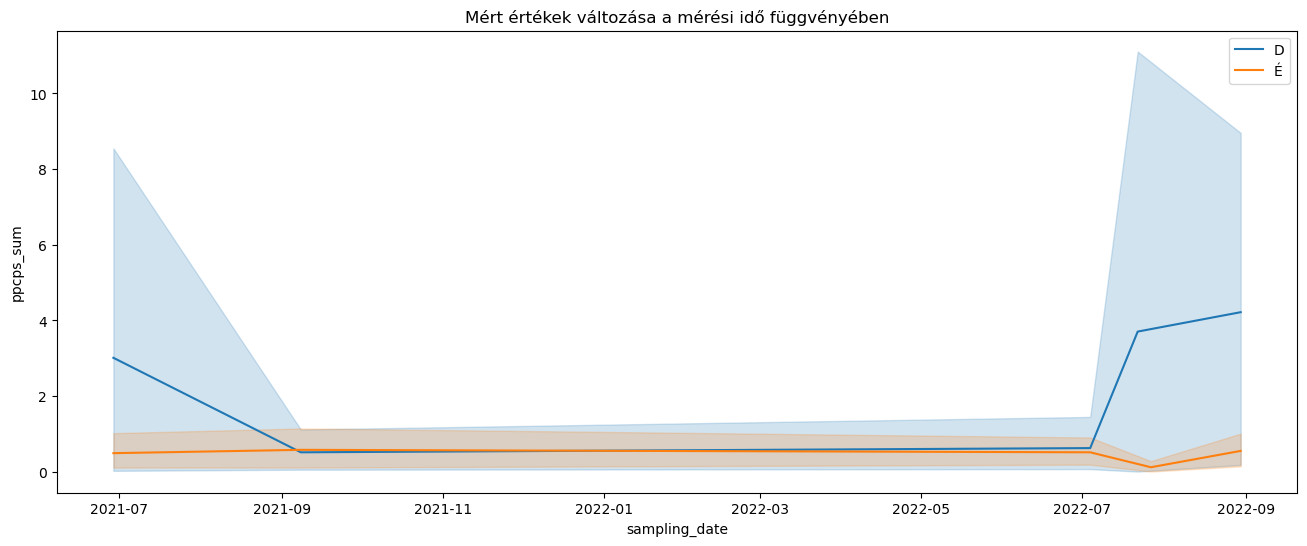

In [208]:
plt.figure(figsize=(16, 6))

sns.lineplot(data=data3_sorted, x=data3_sorted.index, y="ppcps_sum", hue="location")
plt.title("Mért értékek változása a mérési idő függvényében")

plt.legend()
plt.show()

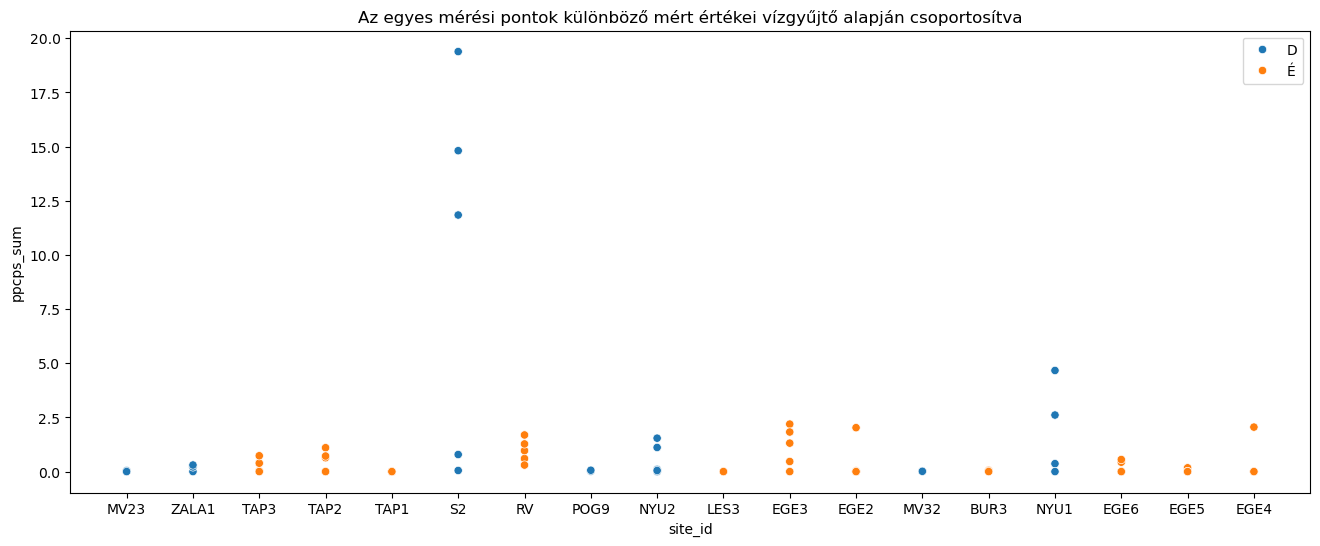

In [207]:
plt.figure(figsize=(16, 6))

sns.scatterplot(data=data3_sorted, x="site_id", y="ppcps_sum", hue="location")
plt.title("Az egyes mérési pontok különböző mért értékei vízgyűjtő alapján csoportosítva")

plt.legend()
plt.show()

Ez érdekes, itt azt lehet látni, hogy az S2 mérései azok, amik nagyon felhúzzák a Dél átlagát, de összességében Az Északnak mintha több határérték fölötti mérése lenne. Az S2-t pár mérését ki lehetne szűrni, mint outliert, de tartok tőle ezzel fontos infót vesztenénk. 

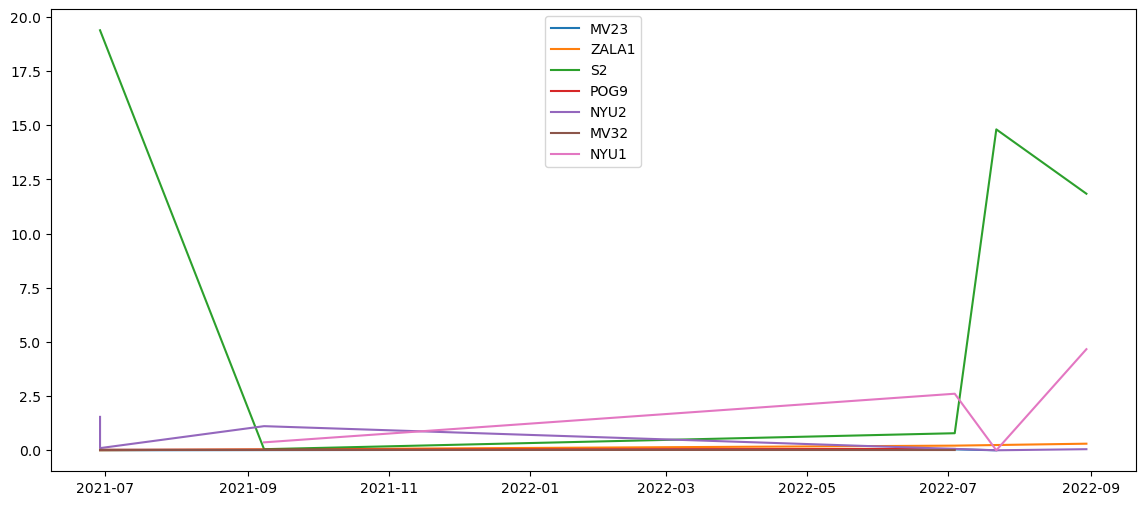

In [251]:

south_sites = data3_sorted.loc[data3_sorted["location"] == "D", "site_id"].unique()

plt.figure(figsize=(14, 6))
for site in south_sites:
    site_data = data3_sorted[data3_sorted["site_id"] == site]
    plt.plot(site_data.index, site_data["ppcps_sum"], label=site)
plt.legend()
plt.show()

Csak az S2 lóg ki - nem tudom mi történhetett itt, vagy mihez van közel, talán városhoz. Nyár végére felmegy ppcp-k (pharmaceuticals and personal care products) összesített koncentrációja, de csak a 7. és 9. hó között, utána visszaáll határéték alá. Talán üdülőterülethez van közel?

In [221]:
data3_north = data3_sorted[data3_sorted["location"] == "É"]
data3_south = data3_sorted[data3_sorted["location"] == "D"]

In [231]:
# Calculate autocorrelation
autocorr_n = data3_north["ppcps_sum"].autocorr()
autocorr_s = data3_south["ppcps_sum"].autocorr()

print("Autocorrelation of north sites: ", np.round(autocorr_n, 2))
print("Autocorrelation of south sites: ", np.round(autocorr_s, 2))

Autocorrelation of north sites:  0.08
Autocorrelation of south sites:  -0.22


In [236]:
acf_sum_n = acf(data3_north["ppcps_sum"])
acf_sum_s = acf(data3_south["ppcps_sum"])

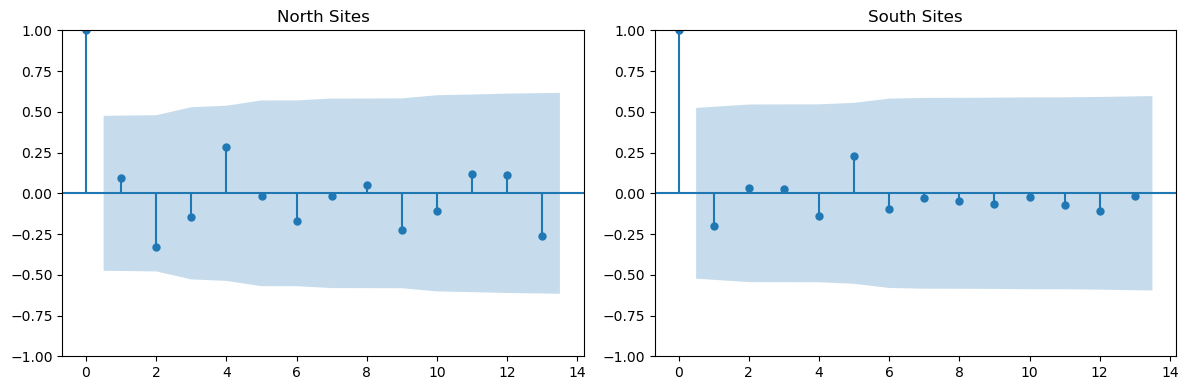

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(acf_sum_n, ax=axes[0], lags=13)
axes[0].set_title("North Sites")

plot_acf(acf_sum_s, ax=axes[1], lags=13)
axes[1].set_title("South Sites")

plt.tight_layout()
plt.show()


Az autokorreláció is azt mutatja, hogy nincs szignifikáns szezonális hatás az északi és déli vízgyűjtőkön a ppcp-k terén.

### Pesticids

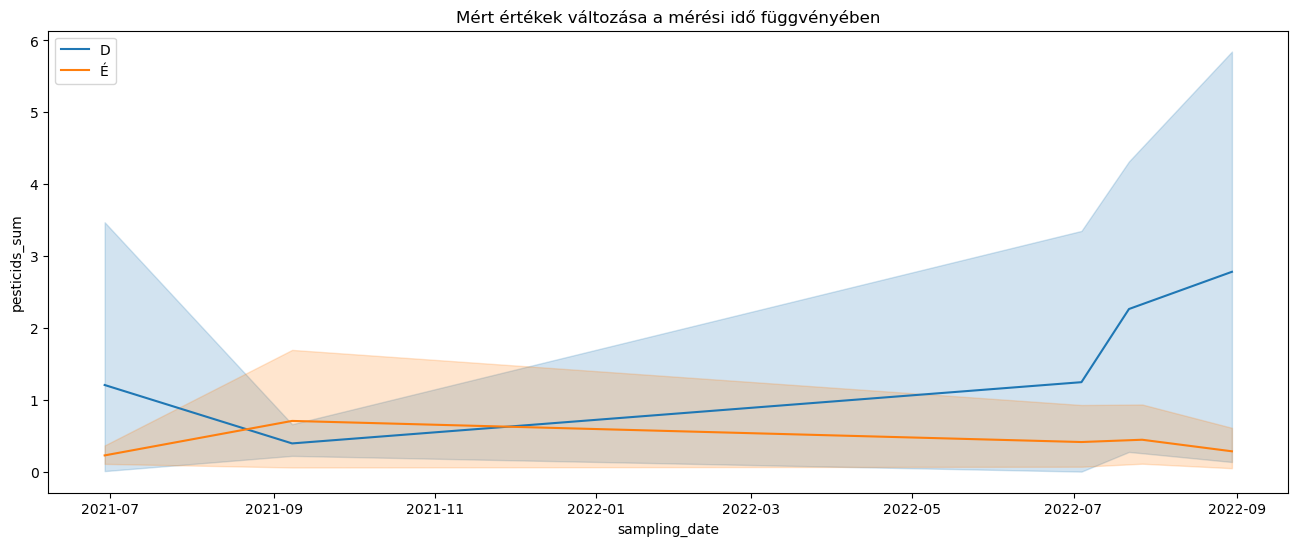

In [253]:
plt.figure(figsize=(16, 6))

sns.lineplot(data=data3_sorted, x=data3_sorted.index, y="pesticids_sum", hue="location")
plt.title("Mért értékek változása a mérési idő függvényében")

plt.legend()
plt.show()

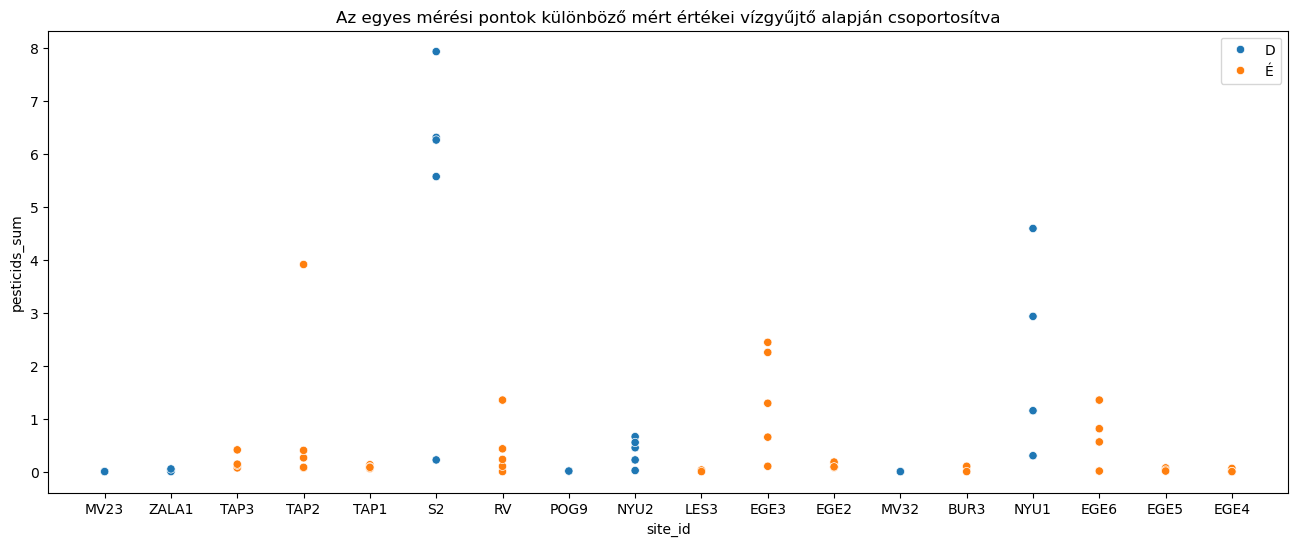

In [254]:
plt.figure(figsize=(16, 6))

sns.scatterplot(data=data3_sorted, x="site_id", y="pesticids_sum", hue="location")
plt.title("Az egyes mérési pontok különböző mért értékei vízgyűjtő alapján csoportosítva")

plt.legend()
plt.show()

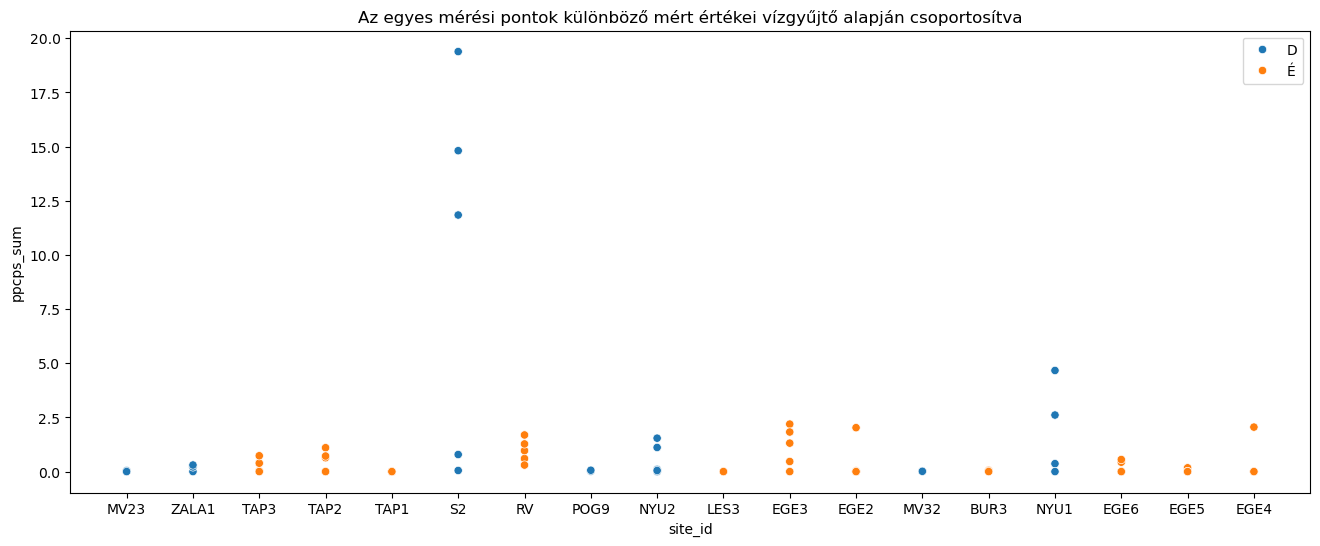

In [255]:
plt.figure(figsize=(16, 6))

sns.scatterplot(data=data3_sorted, x="site_id", y="ppcps_sum", hue="location")
plt.title("Az egyes mérési pontok különböző mért értékei vízgyűjtő alapján csoportosítva")

plt.legend()
plt.show()

Ez érdekes, úgy tűnik itt is az S2 emelkedik ki és egyébként is hasonlóak az eredmények a ppcp-kel. Meg kellene nézni van-e együttjárás a kettő között. (Talán ezzel kellett volna kezdeni)

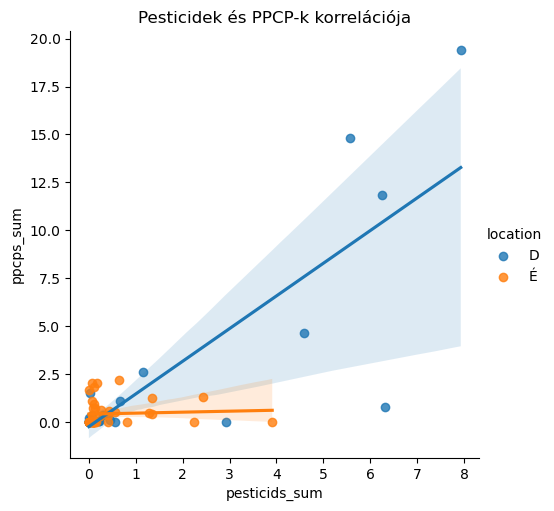

In [257]:
sns.lmplot(data=data3_sorted, x="pesticids_sum", y="ppcps_sum", hue="location")
plt.title("Pesticidek és PPCP-k korrelációja")
plt.show()

Itt az látszi, hogy a magasabb peszticid koncentráció magaabb ppcp koncentrációval jár együtt. Ez eseetben mégis inkább városról van szó és nem üdülőterületről, hacsak nem folyik aktív mezőgazdasági munk a terület közelében. Illetve, manuálisan meg kellene nézni, hogy pontosan mely peszticidek és ppcp-k okozzák a kiugró értékeket, azzal tisztábban látnánk. Fontos lenne még tudni, hogy a különbség nem azért van-e, mert az S2 ponton sokkal több fajta anyagra teszteltetek? 

In [285]:
normality_ppcps = pg.normality(data3_sorted["ppcps_sum"], method="shapiro")
normality_pesticids = pg.normality(data3_sorted["pesticids_sum"], method="shapiro")
print(normality_ppcps)
print(normality_pesticids)

                  W          pval  normal
ppcps_sum  0.373825  1.294031e-15   False
                      W          pval  normal
pesticids_sum  0.530064  1.600744e-13   False


In [281]:
corr_results = pg.corr(data3_sorted["ppcps_sum"], data3_sorted["pesticids_sum"], method="spearman")

print(corr_results)

           n         r        CI95%     p-val    power
spearman  69  0.421315  [0.21, 0.6]  0.000312  0.95667


In [277]:
# Calculate spearman correlation
corr_north = pg.corr(data3_north["ppcps_sum"], data3_north["pesticids_sum"], method="spearman")
corr_south = pg.corr(data3_south["ppcps_sum"], data3_south["pesticids_sum"], method="spearman")

print(corr_north)

           n         r         CI95%     p-val     power
spearman  45  0.311363  [0.02, 0.55]  0.037344  0.558508


In [278]:
print(corr_south)

           n         r         CI95%     p-val     power
spearman  24  0.632023  [0.31, 0.83]  0.000923  0.934552


Minkettő esetében szignifikáns együttjárás van, különös a déli terület esetén magas az együttható: r=0.6 és masszív statisztikai erővel: power=0.93. Viszont itt is látszik, hogy északon kétszer annyi mérési pont volt, mint délen.

In [286]:
acf_sum_pest_n = acf(data3_north["pesticids_sum"])
acf_sum_pest_s = acf(data3_south["pesticids_sum"])

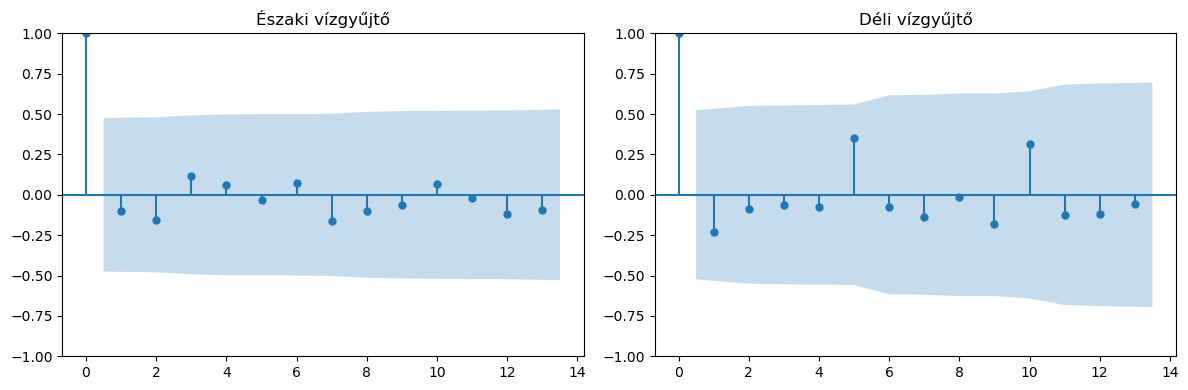

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(acf_sum_pest_n, ax=axes[0], lags=13)
axes[0].set_title("Északi vízgyűjtő")

plot_acf(acf_sum_pest_s, ax=axes[1], lags=13)
axes[1].set_title("Déli vízgyűjtő")

plt.tight_layout()
plt.show()

Ugyanúgy nincs szezonális hatás a peszticidek terén sem

## Conclusion
- Nem találtam sajnos semmilyen szignifikáns különbséget az évek, illetve a vízgyűjtő területek között sem. 
- Esetleg megérné még más módszerekkel is megvizsgálni, valahogy vizualizálni a mérési pontokat, például hálózatelemzéssel, akár térképre vetítve az egyes pontokat, feltüntetve vízgyűjtő területeket is. 
- Magas volt a korreláció a peszticidek összértéke és a ppcp-k összértéke között. 
- Az S2 mérési ponton kiemelkedő értékek voltak július és szeptember között. Ez okozhatta a magas korrelációt is.
- Az S2-t leszámítva, nem volt más szezonális hatás.
- Meg kell nézni, hogy ezen a ponton több fajta kemikáliát is mértetek? Ez okozhatja a kiugró értékeket, ezt manuálisan tudod megnézni. És egyébként az eredményeket is negatívan befolyásolja.
- Ha igen, akkor célszerű lenne kiemelni pár peszticidet és ppcp-t, amit minden egyes ponton mértetek (ha van ilyen) és úgy lefuttatni az elemzést.